#  Analyse the quality of the PSF for target with Ronchi

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : April 23th  2021
- update : April 25th 2021
- version v2.0


# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

In [3]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [4]:
from datetime import datetime,date

In [5]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [6]:
string_date

'2021-04-25'

In [7]:
from iminuit import Minuit
import iminuit

In [8]:
iminuit.__version__

'2.2.0'

In [9]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.spectrum import Spectrum, detect_lines
from spectractor.extractor.spectrum import *
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [10]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [11]:
from time import sleep

In [12]:
from astropy.time import Time
import astropy.units as u

# Function

In [22]:
def file_target(filename):
    m=re.findall('^Cor_ronchi170lpmm_.*_(.*)_[0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*[.]fits$',filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []

# Logbook for file selection

In [13]:
filename_logbook='logbooks/auxtellogbook_2021_ronchi_v1.1.csv'
filename_logbook_out_csv='logbooks/auxtellogbook_2021_ronchi_v1.2.csv'
filename_logbook_out_excel='logbooks/auxtellogbook_2021_ronchi_v1.2.xlsx'

In [14]:
df_in=pd.read_csv(filename_logbook,index_col=0)

In [15]:
pd.set_option('display.max_rows', None)

In [16]:
df_in

index                     date  \
0       0  2021-03-12T01:19:36.315   
1       1  2021-03-12T01:20:18.220   
2       2  2021-03-12T01:20:33.072   
3       3  2021-03-12T01:52:19.566   
4       4  2021-03-12T01:52:28.549   
5       5  2021-03-12T01:52:38.095   
6       6  2021-03-12T01:52:47.124   
7       7  2021-03-12T02:00:08.356   
8       8  2021-03-12T02:01:03.092   
9       9  2021-03-12T02:01:12.571   
10     10  2021-03-12T02:01:25.066   
11     11  2021-03-12T02:01:34.539   
12     12  2021-03-12T02:01:43.667   
13     13  2021-03-12T02:01:53.077   
14     14  2021-03-12T02:02:02.543   
15     15  2021-03-12T02:02:11.707   
16     16  2021-03-12T02:02:20.726   
17     17  2021-03-12T02:02:30.345   
18     18  2021-03-12T02:02:39.259   
19     19  2021-03-12T02:07:37.537   
20     20  2021-03-12T02:07:46.520   
21     21  2021-03-12T02:07:56.080   
22     22  2021-03-12T02:08:05.549   
23     23  2021-03-12T02:08:14.673   
24     24  2021-03-12T02:08:24.308   
25     25  2021-03-12T02:08:33.212   
26     26  2021-03-12T02:08:42.267   
27     27  2021-03-12T02:08:51.794   
28     28  2021-03-12T02:09:00.972   
29     29  2021-03-12T02:09:09.968   
30     30  2021-03-12T02:09:19.024   
31     31  2021-03-12T02:09:28.107   
32     32  2021-03-12T02:09:37.123   
33     33  2021-03-12T02:09:46.801   
34     34  2021-03-12T02:09:55.707   
35     35  2021-03-12T02:10:05.242   
36     36  2021-03-12T02:10:14.155   
37     37  2021-03-12T02:10:23.897   
38     38  2021-03-12T02:10:32.835   
39     39  2021-03-12T02:10:41.829   
40     40  2021-03-12T02:12:55.272   
41     41  2021-03-12T02:13:24.878   
42     42  2021-03-12T02:13:54.363   
43     43  2021-03-12T02:14:23.894   
44     44  2021-03-12T02:14:52.838   
45     45  2021-03-12T02:15:22.506   
46     46  2021-03-12T02:15:51.673   
47     47  2021-03-12T02:16:20.767   
48     48  2021-03-12T02:16:50.340   
49     49  2021-03-12T02:17:20.093   
50     50  2021-03-12T02:17:50.002   
51     51  2021-03-12T02:18:18.901   
52     52  2021-03-12T02:18:48.651   
53     53  2021-03-12T02:19:17.846   
54     54  2021-03-12T02:19:46.942   
55     55  2021-03-12T02:20:16.111   
56     56  2021-03-12T02:20:45.228   
57     57  2021-03-12T02:21:14.248   
58     58  2021-03-12T02:21:43.355   
59     59  2021-03-12T02:22:13.199   
60     60  2021-03-12T02:22:42.038   
61     61  2021-03-12T02:25:01.311   
62     62  2021-03-12T02:26:52.471   
63     63  2021-03-12T02:28:09.532   
64     64  2021-03-12T02:28:48.618   
65     65  2021-03-12T02:31:45.865   
66     66  2021-03-12T02:32:14.768   
67     67  2021-03-12T02:32:44.376   
68     68  2021-03-12T02:33:13.844   
69     69  2021-03-12T02:33:43.257   
70     70  2021-03-12T02:34:12.421   
71     71  2021-03-12T02:34:41.512   
72     72  2021-03-12T02:35:10.639   
73     73  2021-03-12T02:35:39.746   
74     74  2021-03-12T02:36:08.899   
75     75  2021-03-12T02:36:38.134   
76     76  2021-03-12T02:37:07.225   
77     77  2021-03-12T02:37:36.328   
78     78  2021-03-12T02:38:05.425   
79     79  2021-03-12T02:38:34.539   
80     80  2021-03-12T02:39:03.636   
81     81  2021-03-12T02:39:32.732   
82     82  2021-03-12T02:40:01.877   
83     83  2021-03-12T02:40:31.045   
84     84  2021-03-12T02:41:00.031   
85     85  2021-03-12T02:41:29.145   

                                                 path  \
0   /sps/lsst/groups/auxtel/data/2021/ronchi170lpm...   
1   /sps/lsst/groups/auxtel/data/2021/ronchi170lpm...   
2   /sps/lsst/groups/auxtel/data/2021/ronchi170lpm...   
3   /sps/lsst/groups/auxtel/data/2021/ronchi170lpm...   
4   /sps/lsst/groups/auxtel/data/2021/ronchi170lpm...   
5   /sps/lsst/groups/auxtel/data/2021/ronchi170lpm...   
6   /sps/lsst/groups/auxtel/data/2021/ronchi170lpm...   
7   /sps/lsst/groups/auxtel/data/2021/ronchi170lpm...   
8   /sps/lsst/groups/auxtel/data/2021/ronchi170lpm...   
9   /sps/lsst/groups/auxtel/data/2021/ronchi170lpm...   
10  /sps/lsst/groups/auxtel/data/2021/ronchi170lpm...   
11  /sps/lsst

# Selection of input file


- the target coordinates 'Obj-posXpix','Obj-posYpix' must exists.

### Drop NA

In [17]:
#df.dropna(how='any', subset=['Obj-posXpix','Obj-posYpix'],inplace=True)
df=df_in.dropna(how='any', subset=['Obj-posXpix','Obj-posYpix'])

### Drop bad quality

In [20]:
#i = df[(df.run != 1) | (df.quality != 1)].index

In [21]:
#i

In [22]:
#df.drop(i,inplace=True)

## View

In [18]:
df

index                     date  \
0       0  2021-03-12T01:19:36.315   
1       1  2021-03-12T01:20:18.220   
2       2  2021-03-12T01:20:33.072   
3       3  2021-03-12T01:52:19.566   
4       4  2021-03-12T01:52:28.549   
5       5  2021-03-12T01:52:38.095   
6       6  2021-03-12T01:52:47.124   
7       7  2021-03-12T02:00:08.356   
8       8  2021-03-12T02:01:03.092   
9       9  2021-03-12T02:01:12.571   
10     10  2021-03-12T02:01:25.066   
11     11  2021-03-12T02:01:34.539   
12     12  2021-03-12T02:01:43.667   
13     13  2021-03-12T02:01:53.077   
14     14  2021-03-12T02:02:02.543   
15     15  2021-03-12T02:02:11.707   
16     16  2021-03-12T02:02:20.726   
17     17  2021-03-12T02:02:30.345   
18     18  2021-03-12T02:02:39.259   
19     19  2021-03-12T02:07:37.537   
20     20  2021-03-12T02:07:46.520   
21     21  2021-03-12T02:07:56.080   
22     22  2021-03-12T02:08:05.549   
23     23  2021-03-12T02:08:14.673   
24     24  2021-03-12T02:08:24.308   
25     25  2021-03-12T02:08:33.212   
26     26  2021-03-12T02:08:42.267   
27     27  2021-03-12T02:08:51.794   
28     28  2021-03-12T02:09:00.972   
29     29  2021-03-12T02:09:09.968   
30     30  2021-03-12T02:09:19.024   
31     31  2021-03-12T02:09:28.107   
32     32  2021-03-12T02:09:37.123   
33     33  2021-03-12T02:09:46.801   
34     34  2021-03-12T02:09:55.707   
35     35  2021-03-12T02:10:05.242   
36     36  2021-03-12T02:10:14.155   
37     37  2021-03-12T02:10:23.897   
38     38  2021-03-12T02:10:32.835   
39     39  2021-03-12T02:10:41.829   
40     40  2021-03-12T02:12:55.272   
41     41  2021-03-12T02:13:24.878   
42     42  2021-03-12T02:13:54.363   
43     43  2021-03-12T02:14:23.894   
44     44  2021-03-12T02:14:52.838   
45     45  2021-03-12T02:15:22.506   
46     46  2021-03-12T02:15:51.673   
47     47  2021-03-12T02:16:20.767   
48     48  2021-03-12T02:16:50.340   
49     49  2021-03-12T02:17:20.093   
50     50  2021-03-12T02:17:50.002   
51     51  2021-03-12T02:18:18.901   
52     52  2021-03-12T02:18:48.651   
53     53  2021-03-12T02:19:17.846   
54     54  2021-03-12T02:19:46.942   
55     55  2021-03-12T02:20:16.111   
56     56  2021-03-12T02:20:45.228   
57     57  2021-03-12T02:21:14.248   
58     58  2021-03-12T02:21:43.355   
59     59  2021-03-12T02:22:13.199   
60     60  2021-03-12T02:22:42.038   
61     61  2021-03-12T02:25:01.311   
62     62  2021-03-12T02:26:52.471   
63     63  2021-03-12T02:28:09.532   
64     64  2021-03-12T02:28:48.618   
65     65  2021-03-12T02:31:45.865   
66     66  2021-03-12T02:32:14.768   
67     67  2021-03-12T02:32:44.376   
68     68  2021-03-12T02:33:13.844   
69     69  2021-03-12T02:33:43.257   
70     70  2021-03-12T02:34:12.421   
71     71  2021-03-12T02:34:41.512   
72     72  2021-03-12T02:35:10.639   
73     73  2021-03-12T02:35:39.746   
74     74  2021-03-12T02:36:08.899   
75     75  2021-03-12T02:36:38.134   
76     76  2021-03-12T02:37:07.225   
77     77  2021-03-12T02:37:36.328   
78     78  2021-03-12T02:38:05.425   
79     79  2021-03-12T02:38:34.539   
80     80  2021-03-12T02:39:03.636   
81     81  2021-03-12T02:39:32.732   
82     82  2021-03-12T02:40:01.877   
83     83  2021-03-12T02:40:31.045   
84     84  2021-03-12T02:41:00.031   
85     85  2021-03-12T02:41:29.145   

                                                 path  \
0   /sps/lsst/groups/auxtel/data/2021/ronchi170lpm...   
1   /sps/lsst/groups/auxtel/data/2021/ronchi170lpm...   
2   /sps/lsst/groups/auxtel/data/2021/ronchi170lpm...   
3   /sps/lsst/groups/auxtel/data/2021/ronchi170lpm...   
4   /sps/lsst/groups/auxtel/data/2021/ronchi170lpm...   
5   /sps/lsst/groups/auxtel/data/2021/ronchi170lpm...   
6   /sps/lsst/groups/auxtel/data/2021/ronchi170lpm...   
7   /sps/lsst/groups/auxtel/data/2021/ronchi170lpm...   
8   /sps/lsst/groups/auxtel/data/2021/ronchi170lpm...   
9   /sps/lsst/groups/auxtel/data/2021/ronchi170lpm...   
10  /sps/lsst/groups/auxtel/data/2021/ronchi170lpm...   
11  /sps/lsst

In [19]:
myhome=os.getenv("HOME")
dir_images=os.path.join(myhome,"DATA/AuxTelData2021/ronchi170lpmm/FlipCleans")

In [20]:
disperser_label = "ronchi170lpmm"
config = "config/auxtel_quicklook.ini"

In [23]:
idx=0
for filename_image in df["file"]:
    
    fullfilename=os.path.join(dir_images,filename_image)
    X=df.iloc[idx]["Obj-posXpix"]
    Y=df.iloc[idx]["Obj-posYpix"]
    guess = [X,Y]
    target = file_target(filename_image)[0]
    print(filename_image," ",target," ",guess)
    idx+=1

Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_188.fits   HD75519   [1800.0, 2500.0]
Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_189.fits   HD75519   [1800.0, 2500.0]
Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_190.fits   HD75519   [1800.0, 2500.0]
Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_200.fits   HD75519   [2100.0, 1750.0]
Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_201.fits   HD75519   [2100.0, 1750.0]
Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_202.fits   HD75519   [2100.0, 1750.0]
Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_203.fits   HD75519   [2100.0, 1750.0]
Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_204.fits   HD75519   [200.0, 1700.0]
Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_205.fits   HD75519   [200.0, 1700.0]
Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_206.fits   HD75519   [200.0, 1700.0]
Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_207.fits   HD75519   [200.0, 1700.0]
Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_208.fits   HD75519   [200.0, 1700.0]
Cor_ronchi170lpmm_RG610_HD75519_2

# Configuration of the running mode

In [24]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

In [25]:
FLAG_SHOW_SPECTRACTOR_IMAGES = False

In [26]:
if FLAG_SHOW_SPECTRACTOR_IMAGES:

    idx=0
    for filename_image in df["file"]:
        
        
        try:
    
            fullfilename=os.path.join(dir_images,filename_image)
            X=df.iloc[idx]["Obj-posXpix"]
            Y=df.iloc[idx]["Obj-posYpix"]
            guess = [int(X),int(Y)]
            target = file_target(filename_image)[0]
            print(idx,")  ",filename_image," ",target," ",guess)
    

            image=Image(file_name=fullfilename, target_label=target, disperser_label=disperser_label, config=config)
            image.plot_image(figsize=(6, 5),scale="log")
            
            x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)
            
            print("x1,y1=",x1," , ",y1)
            
            
        except:
            msg=">>>FAILED : "+str(idx) + ") "+ filename_image + " " + target 
            print(msg)
            pass
            
        
        finally:
            idx+=1

0) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_188.fits HD75519


2021-04-25 14:54:02  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.363283812576087 but average of self.read_out_noise is 8.5.


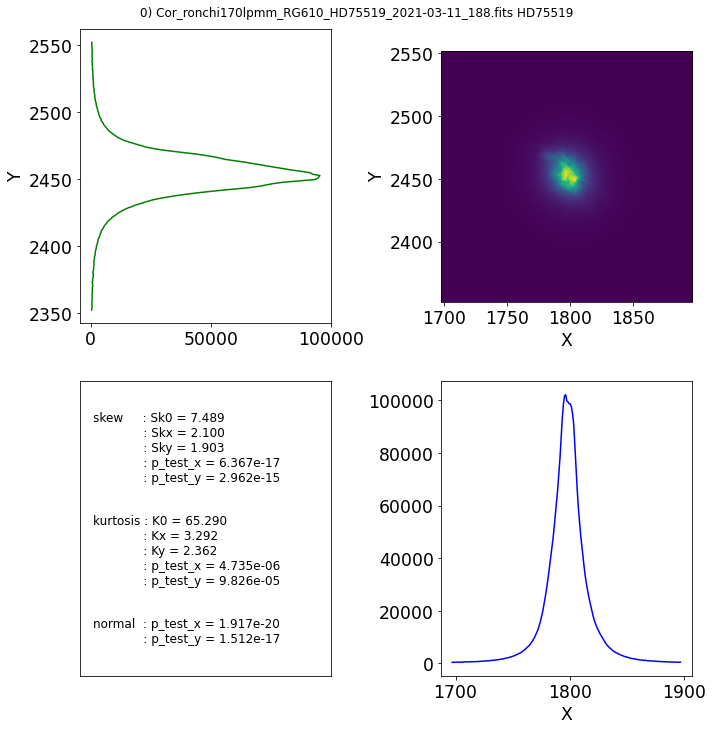

1) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_189.fits HD75519


2021-04-25 14:54:13  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.361855103278568 but average of self.read_out_noise is 8.5.


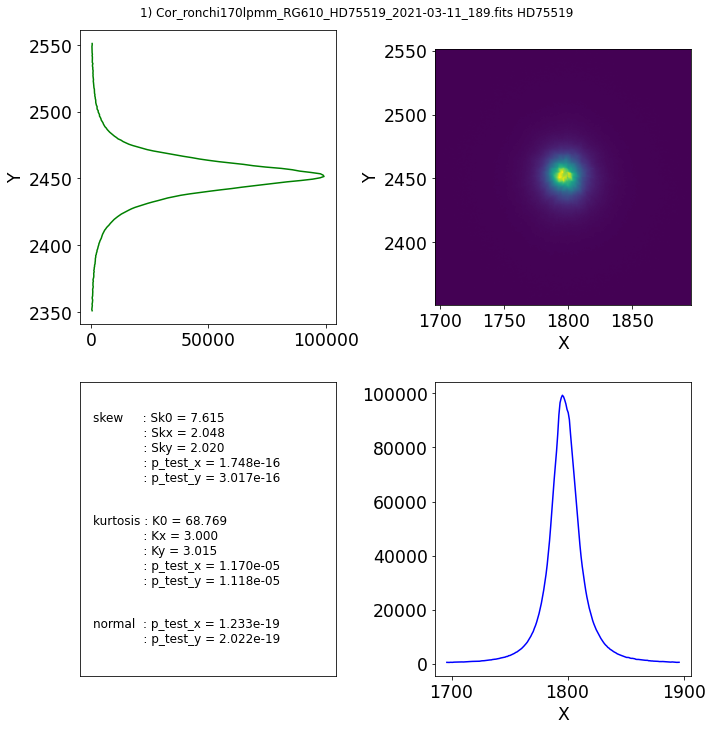

2) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_190.fits HD75519


2021-04-25 14:54:23  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.364087221080966 but average of self.read_out_noise is 8.5.


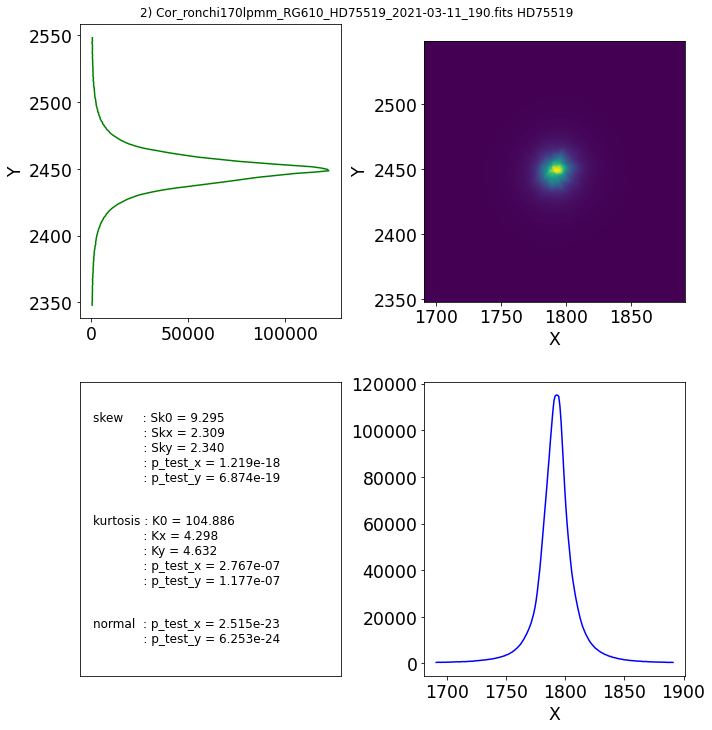

3) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_200.fits HD75519


2021-04-25 14:54:34  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.370810871034847 but average of self.read_out_noise is 8.5.


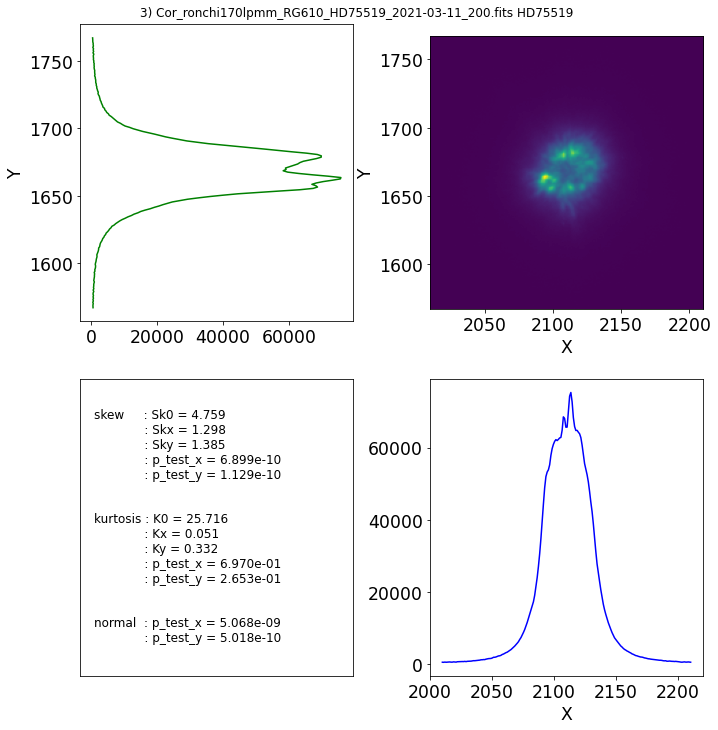

4) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_201.fits HD75519


2021-04-25 14:54:44  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.374783758531402 but average of self.read_out_noise is 8.5.


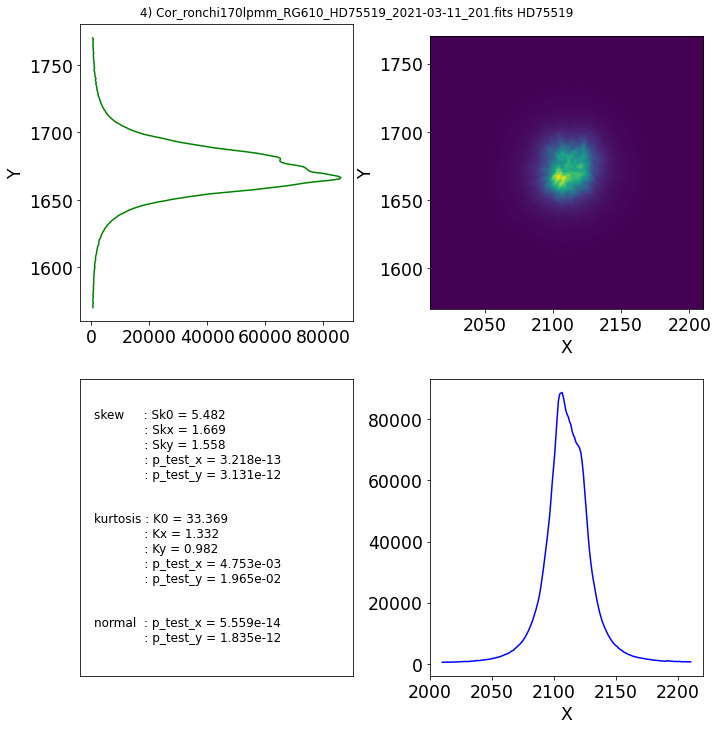

5) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_202.fits HD75519


2021-04-25 14:54:55  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.370533692996718 but average of self.read_out_noise is 8.5.


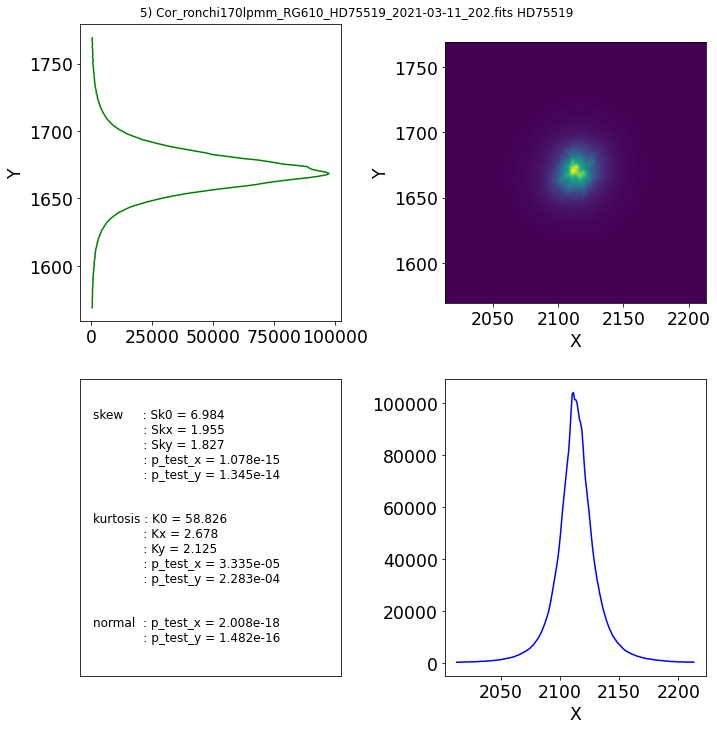

6) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_203.fits HD75519


2021-04-25 14:55:05  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.372883073262662 but average of self.read_out_noise is 8.5.


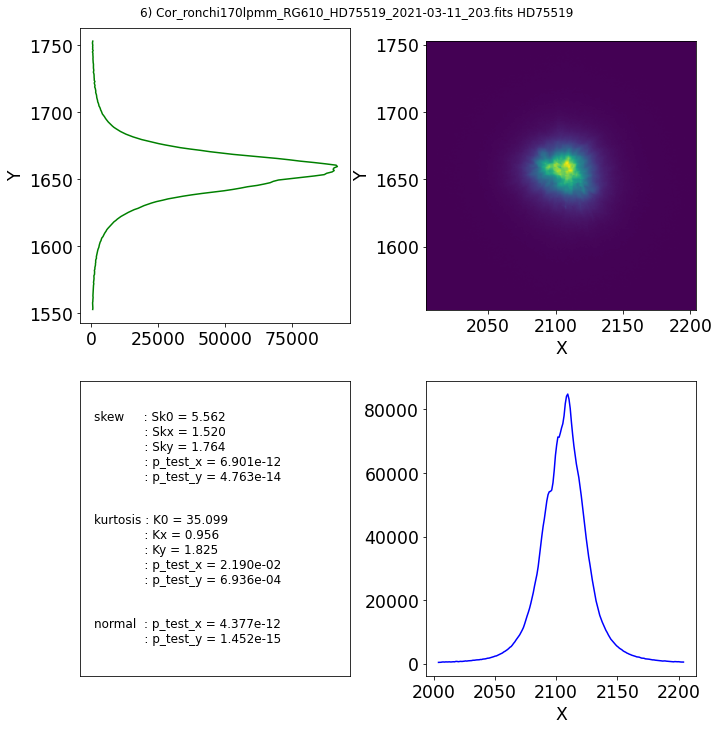

7) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_204.fits HD75519


2021-04-25 14:55:15  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.36971196115288 but average of self.read_out_noise is 8.5.


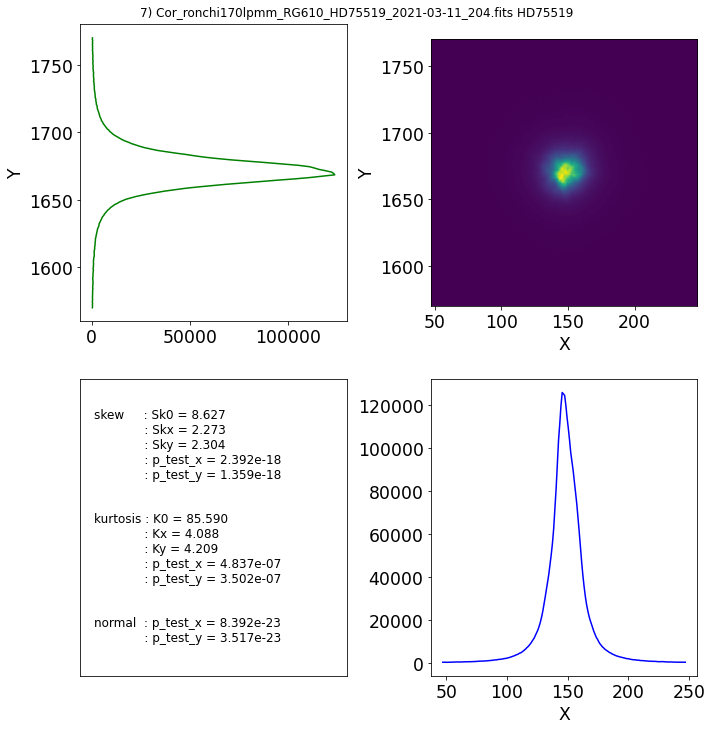

8) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_205.fits HD75519


2021-04-25 14:55:27  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.36801585600352 but average of self.read_out_noise is 8.5.


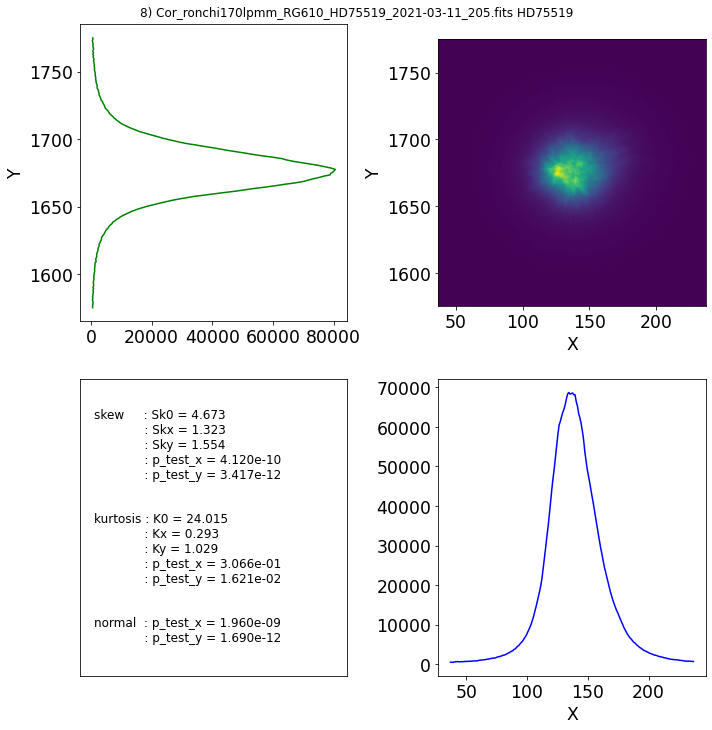

9) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_206.fits HD75519


2021-04-25 14:55:38  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.366923779291042 but average of self.read_out_noise is 8.5.


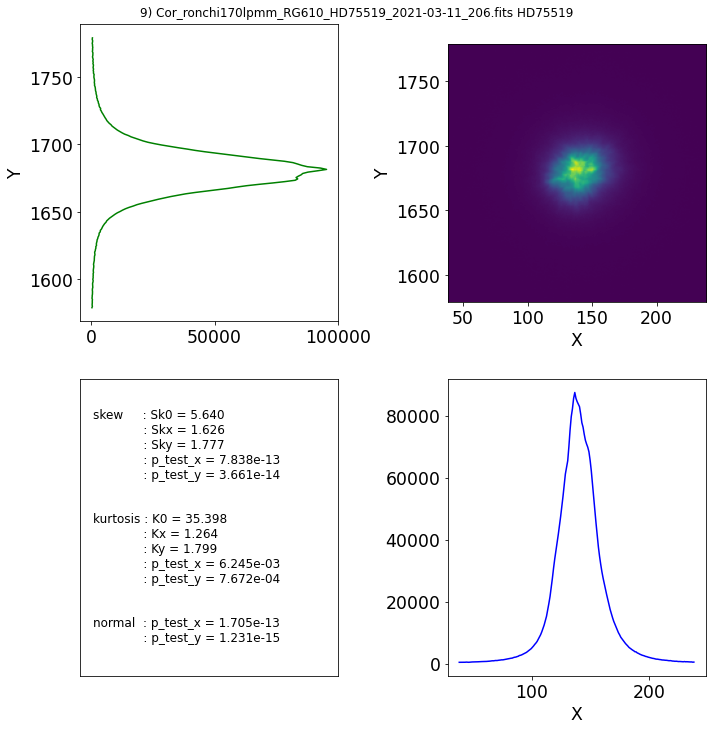

10) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_207.fits HD75519


2021-04-25 14:55:50  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.366478661702116 but average of self.read_out_noise is 8.5.


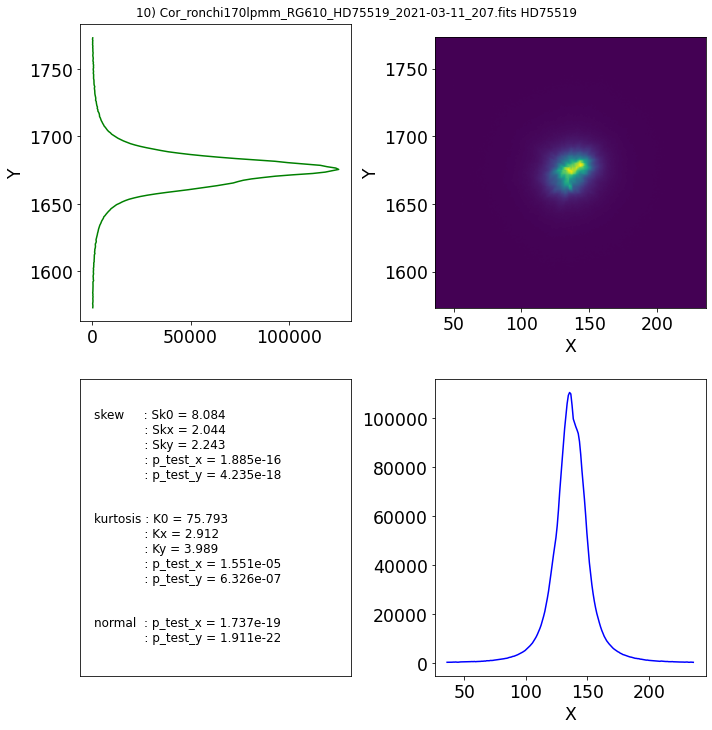

11) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_208.fits HD75519


2021-04-25 14:56:01  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.367942874786367 but average of self.read_out_noise is 8.5.


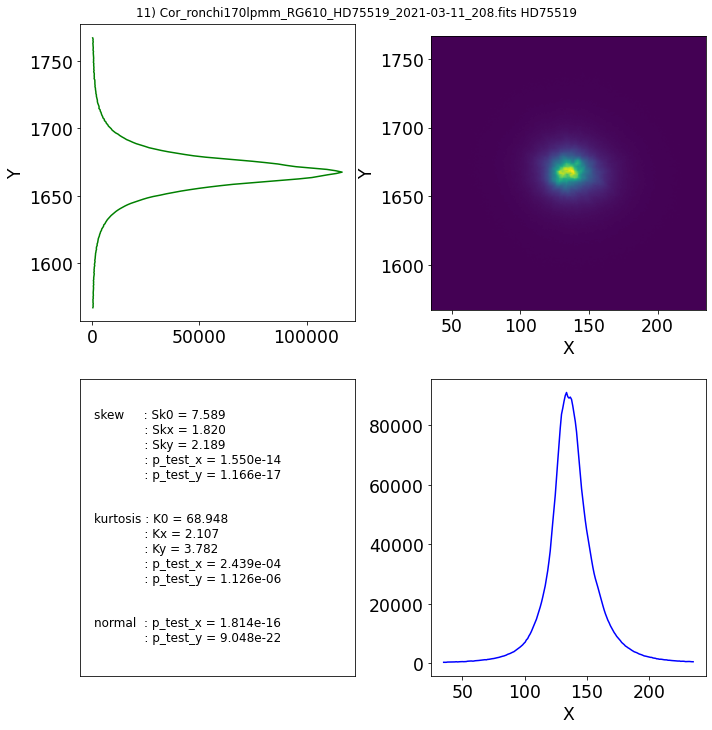

12) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_209.fits HD75519


2021-04-25 14:56:12  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.370031723498427 but average of self.read_out_noise is 8.5.


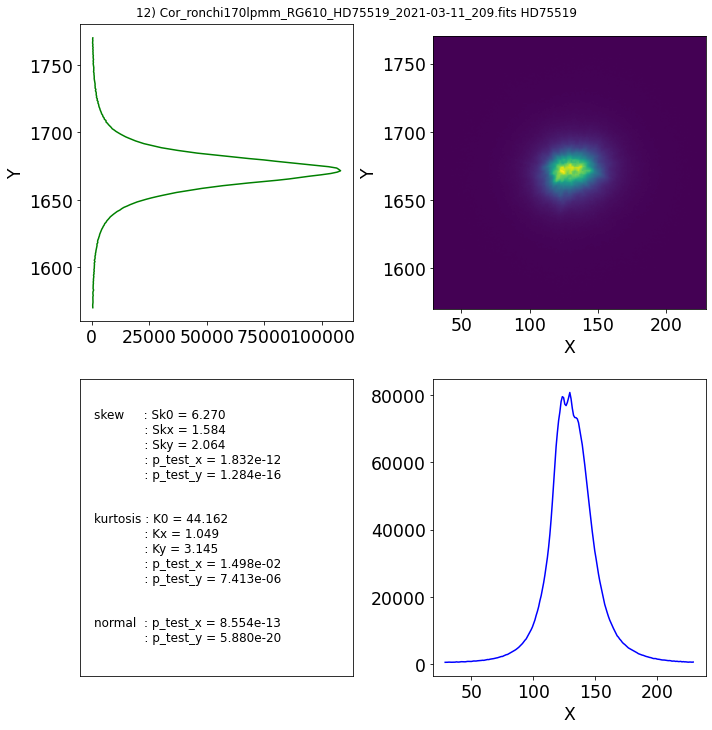

13) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_210.fits HD75519


2021-04-25 14:56:24  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.37028716252344 but average of self.read_out_noise is 8.5.


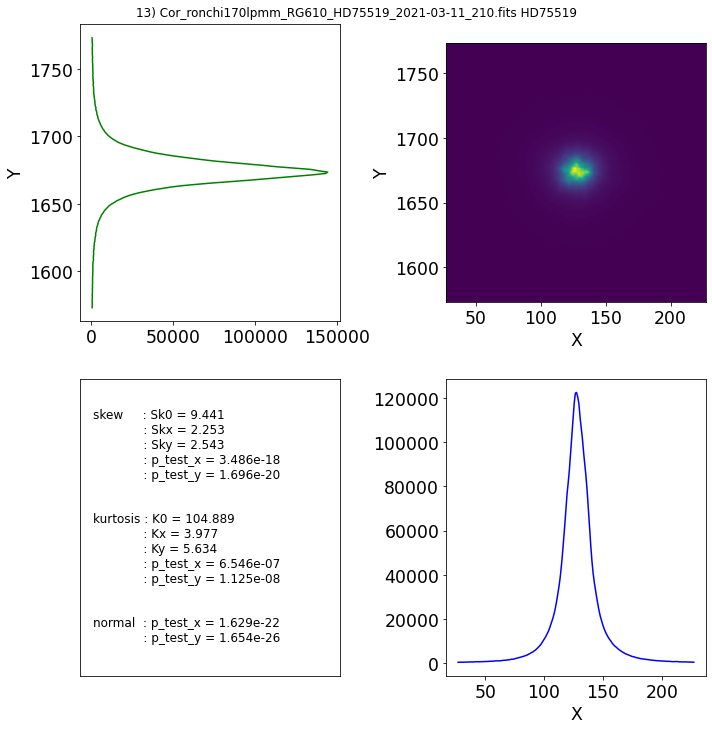

14) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_211.fits HD75519


2021-04-25 14:56:35  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.366643344566612 but average of self.read_out_noise is 8.5.


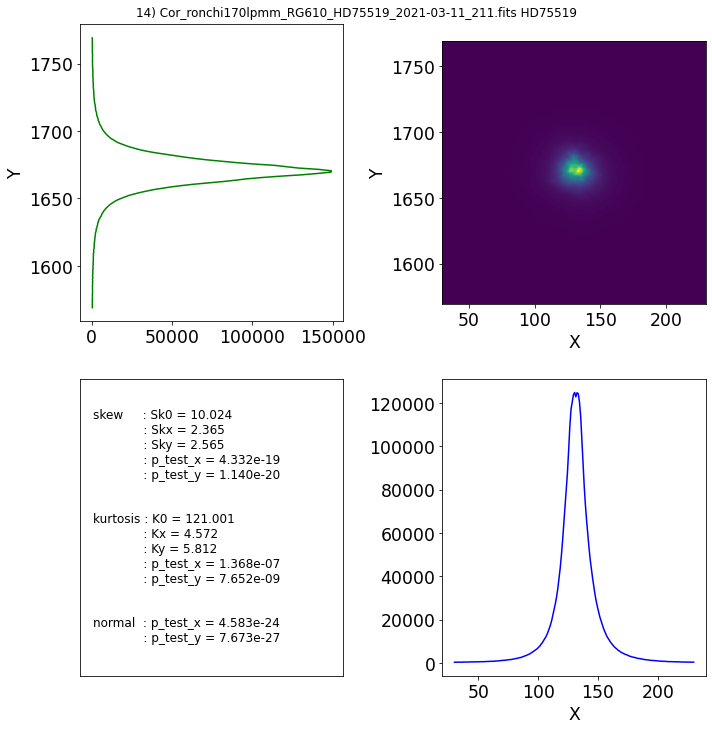

15) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_212.fits HD75519


2021-04-25 14:56:47  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.369469083709852 but average of self.read_out_noise is 8.5.


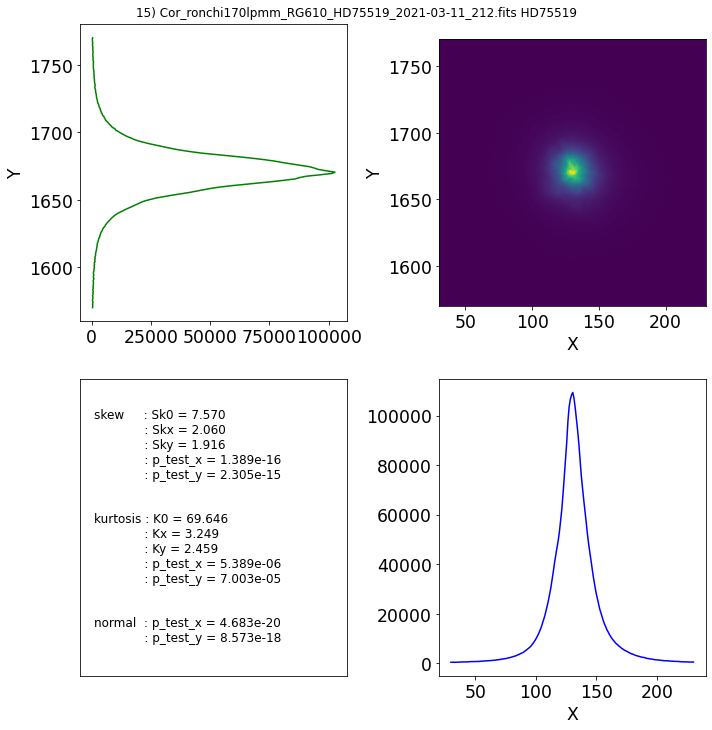

16) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_213.fits HD75519


2021-04-25 14:56:56  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.367648598776624 but average of self.read_out_noise is 8.5.


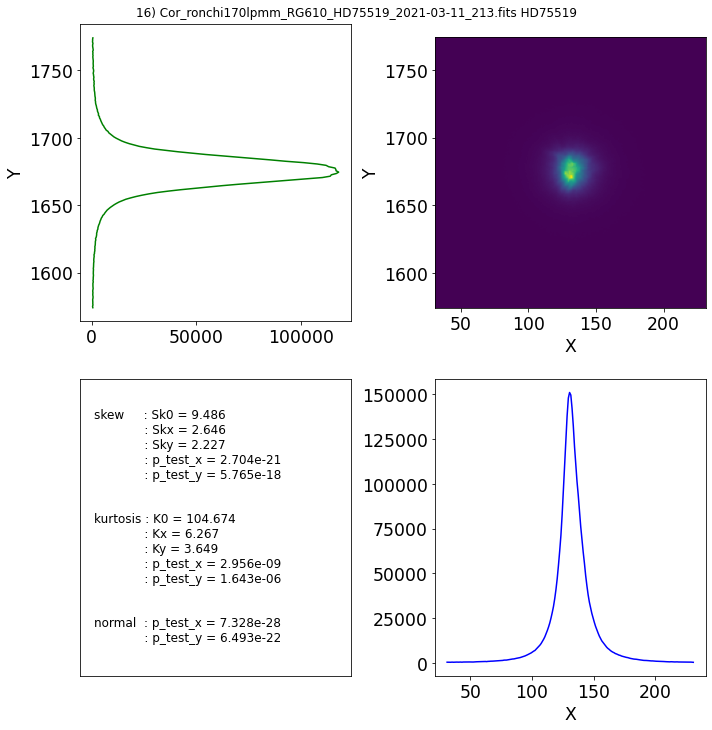

17) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_214.fits HD75519


2021-04-25 14:57:08  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.367892261900414 but average of self.read_out_noise is 8.5.


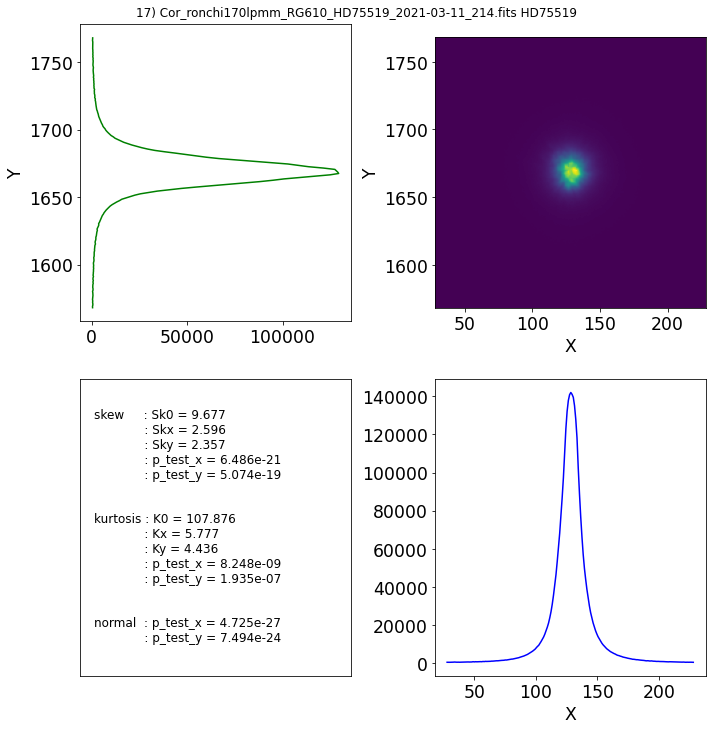

18) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_215.fits HD75519


2021-04-25 14:57:20  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.370484468198525 but average of self.read_out_noise is 8.5.


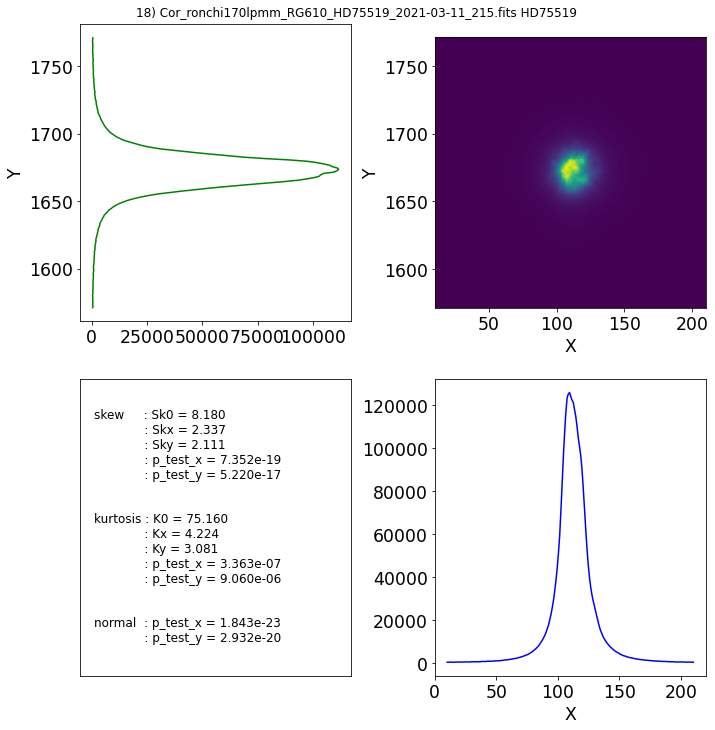

19) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_216.fits HD75519


2021-04-25 14:57:31  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.365266970258162 but average of self.read_out_noise is 8.5.


>>> FAILED : 19) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_216.fits HD75519
>>> FAILED : guess =  [100, 1700]
20) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_217.fits HD75519


2021-04-25 14:57:44  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.36579008418076 but average of self.read_out_noise is 8.5.


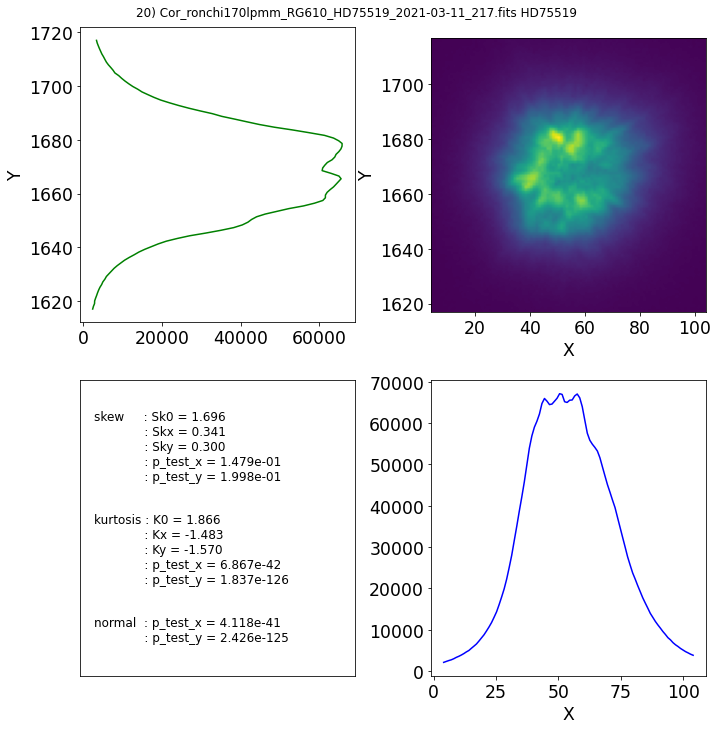

21) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_218.fits HD75519


2021-04-25 14:57:57  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.362432453659567 but average of self.read_out_noise is 8.5.


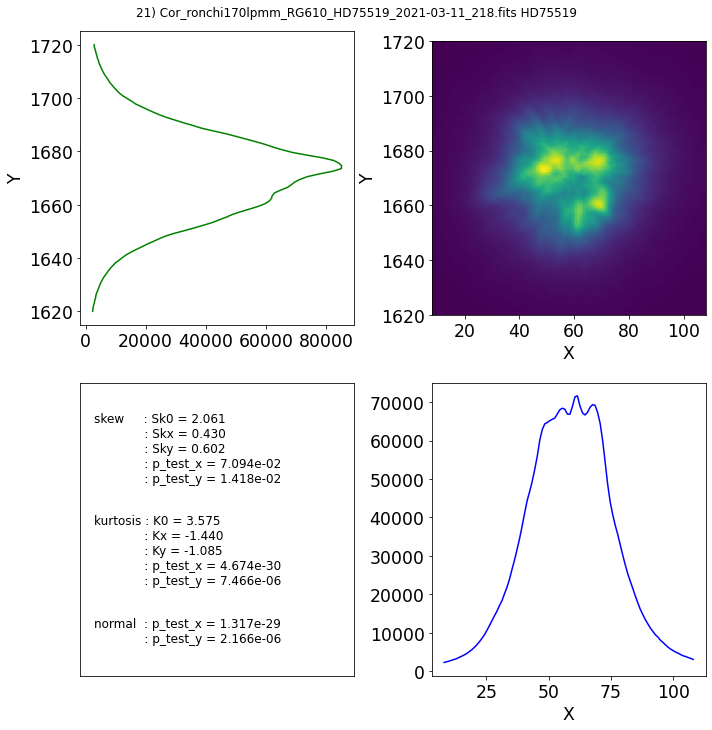

22) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_219.fits HD75519


2021-04-25 14:58:10  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.364925484750515 but average of self.read_out_noise is 8.5.


>>> FAILED : 22) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_219.fits HD75519
>>> FAILED : guess =  [100, 1700]
23) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_220.fits HD75519


2021-04-25 14:58:23  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.368737035283983 but average of self.read_out_noise is 8.5.


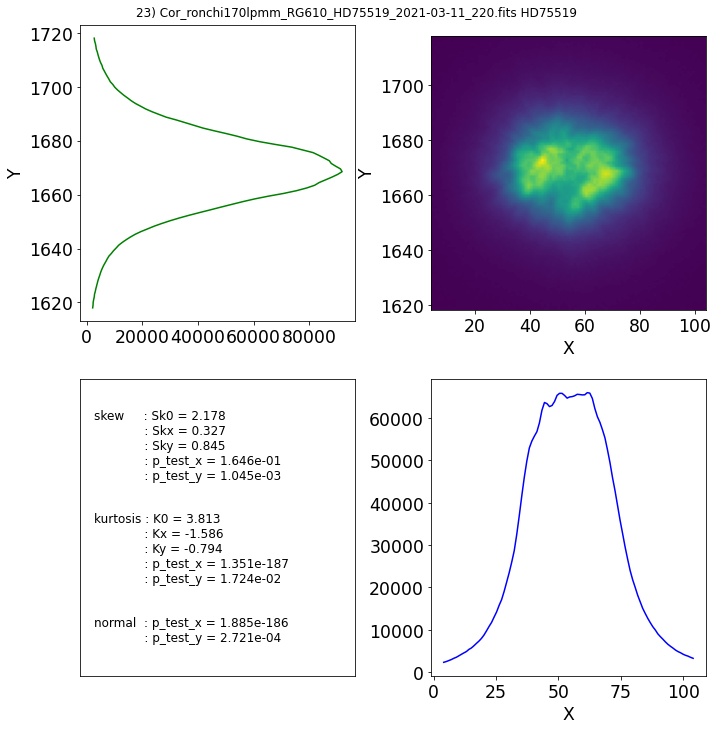

24) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_221.fits HD75519


2021-04-25 14:58:35  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.362348372128938 but average of self.read_out_noise is 8.5.


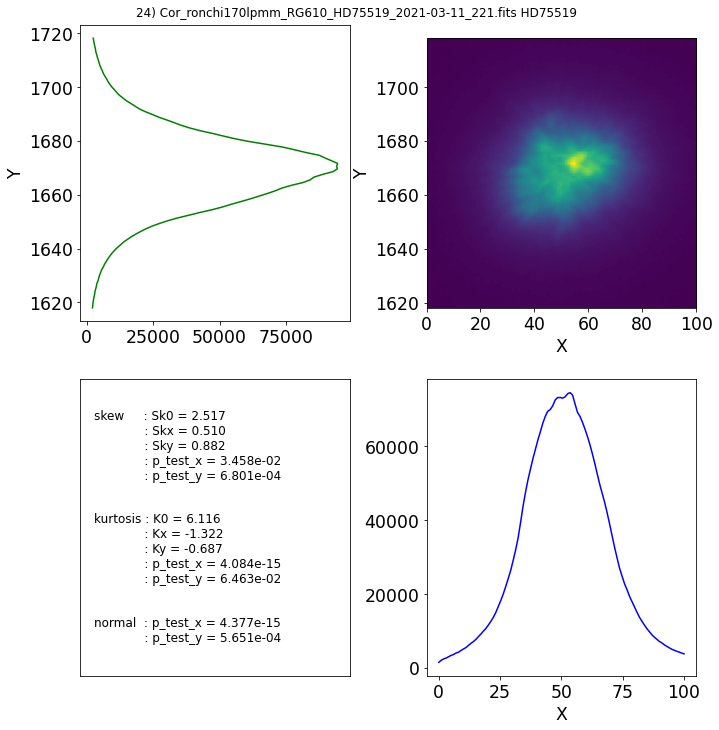

25) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_222.fits HD75519


2021-04-25 14:58:48  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.365034202217837 but average of self.read_out_noise is 8.5.


>>> FAILED : 25) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_222.fits HD75519
>>> FAILED : guess =  [100, 1700]
26) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_223.fits HD75519


2021-04-25 14:59:03  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.366753354987223 but average of self.read_out_noise is 8.5.


>>> FAILED : 26) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_223.fits HD75519
>>> FAILED : guess =  [100, 1700]
27) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_224.fits HD75519


2021-04-25 14:59:13  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.361564572605113 but average of self.read_out_noise is 8.5.


>>> FAILED : 27) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_224.fits HD75519
>>> FAILED : guess =  [100, 1700]
28) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_225.fits HD75519


2021-04-25 14:59:24  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.366325617553931 but average of self.read_out_noise is 8.5.


>>> FAILED : 28) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_225.fits HD75519
>>> FAILED : guess =  [100, 1700]
29) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_226.fits HD75519


2021-04-25 14:59:35  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.36075347114403 but average of self.read_out_noise is 8.5.


>>> FAILED : 29) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_226.fits HD75519
>>> FAILED : guess =  [100, 1700]
30) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_227.fits HD75519


2021-04-25 14:59:45  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.362145645361654 but average of self.read_out_noise is 8.5.


>>> FAILED : 30) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_227.fits HD75519
>>> FAILED : guess =  [100, 1700]
31) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_228.fits HD75519


2021-04-25 14:59:57  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.365213418138005 but average of self.read_out_noise is 8.5.


>>> FAILED : 31) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_228.fits HD75519
>>> FAILED : guess =  [100, 1700]
32) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_229.fits HD75519


2021-04-25 15:00:07  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.365142880592929 but average of self.read_out_noise is 8.5.


>>> FAILED : 32) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_229.fits HD75519
>>> FAILED : guess =  [100, 1700]
33) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_230.fits HD75519


2021-04-25 15:00:18  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.362841936999638 but average of self.read_out_noise is 8.5.


>>> FAILED : 33) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_230.fits HD75519
>>> FAILED : guess =  [100, 1700]
34) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_231.fits HD75519


2021-04-25 15:00:31  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.365019713790709 but average of self.read_out_noise is 8.5.


>>> FAILED : 34) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_231.fits HD75519
>>> FAILED : guess =  [100, 1700]
35) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_232.fits HD75519


2021-04-25 15:00:43  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.364855849003117 but average of self.read_out_noise is 8.5.


>>> FAILED : 35) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_232.fits HD75519
>>> FAILED : guess =  [100, 1700]
36) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_233.fits HD75519


2021-04-25 15:00:54  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.365306290021694 but average of self.read_out_noise is 8.5.


>>> FAILED : 36) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_233.fits HD75519
>>> FAILED : guess =  [100, 1700]
37) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_234.fits HD75519


2021-04-25 15:01:04  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.363694424069275 but average of self.read_out_noise is 8.5.


>>> FAILED : 37) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_234.fits HD75519
>>> FAILED : guess =  [100, 1700]
38) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_235.fits HD75519


2021-04-25 15:01:13  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.364813592308032 but average of self.read_out_noise is 8.5.


>>> FAILED : 38) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_235.fits HD75519
>>> FAILED : guess =  [100, 1700]
39) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_236.fits HD75519


2021-04-25 15:01:23  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.363700703894846 but average of self.read_out_noise is 8.5.


>>> FAILED : 39) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_236.fits HD75519
>>> FAILED : guess =  [100, 1700]
40) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_237.fits HD75519


2021-04-25 15:01:40  Image      find_target_Moffat2D WARNING 
	X=-8.75, Y=82.19 target position determination probably wrong: 19.0 pixels from profile detection (10.07, 79.80)
2021-04-25 15:01:41  Image      find_target_Moffat2D WARNING 
	X=-2.98, Y=49.00 target position determination probably wrong: 13.1 pixels from profile detection (10.05, 47.67)


>>> FAILED : 40) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_237.fits HD75519
>>> FAILED : guess =  [100, 1700]
41) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_238.fits HD75519


2021-04-25 15:01:52  Image      find_target_Moffat2D WARNING 
	X=-18.41, Y=83.81 target position determination probably wrong: 27.4 pixels from profile detection (9.00, 83.33)


>>> FAILED : 41) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_238.fits HD75519
>>> FAILED : guess =  [100, 1700]
42) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_239.fits HD75519


2021-04-25 15:02:03  Image      find_target_Moffat2D WARNING 
	X=-4.59, Y=84.08 target position determination probably wrong: 10.9 pixels from profile detection (6.27, 83.75)
2021-04-25 15:02:05  Image      find_target_Moffat2D WARNING 
	X=-0.93, Y=49.45 target position determination probably wrong: 7.2 pixels from profile detection (6.23, 49.74)


>>> FAILED : 42) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_239.fits HD75519
>>> FAILED : guess =  [100, 1700]
43) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_240.fits HD75519


2021-04-25 15:02:15  Image      find_target_Moffat2D WARNING 
	X=-1.41, Y=85.24 target position determination probably wrong: 5.9 pixels from profile detection (4.52, 85.59)
2021-04-25 15:02:16  Image      find_target_Moffat2D WARNING 
	X=-1.12, Y=50.42 target position determination probably wrong: 5.6 pixels from profile detection (4.44, 50.59)


>>> FAILED : 43) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_240.fits HD75519
>>> FAILED : guess =  [100, 1700]
44) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_241.fits HD75519


2021-04-25 15:02:25  Image      find_target_Moffat2D WARNING 
	X=-5.33, Y=85.78 target position determination probably wrong: 10.2 pixels from profile detection (4.91, 86.18)
2021-04-25 15:02:26  Image      find_target_Moffat2D WARNING 
	X=-1.69, Y=51.17 target position determination probably wrong: 6.4 pixels from profile detection (4.75, 51.13)


>>> FAILED : 44) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_241.fits HD75519
>>> FAILED : guess =  [100, 1700]
45) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_242.fits HD75519


2021-04-25 15:02:36  Image      find_target_Moffat2D WARNING 
	X=-5.65, Y=87.15 target position determination probably wrong: 11.2 pixels from profile detection (5.54, 87.10)
2021-04-25 15:02:37  Image      find_target_Moffat2D WARNING 
	X=-0.40, Y=49.95 target position determination probably wrong: 5.7 pixels from profile detection (5.30, 49.90)


>>> FAILED : 45) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_242.fits HD75519
>>> FAILED : guess =  [100, 1700]
46) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_243.fits HD75519
>>> FAILED : 46) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_243.fits HD75519
>>> FAILED : guess =  [100, 1700]
47) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_244.fits HD75519
>>> FAILED : 47) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_244.fits HD75519
>>> FAILED : guess =  [100, 1700]
48) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_245.fits HD75519
>>> FAILED : 48) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_245.fits HD75519
>>> FAILED : guess =  [100, 1700]
49) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_246.fits HD75519
>>> FAILED : 49) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_246.fits HD75519
>>> FAILED : guess =  [100, 1700]
50) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_247.fits HD75519
>>> FAILED : 50) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_247.fits HD75519
>>> FAILED : guess =  [100, 1700]
51) Cor_ronchi

2021-04-25 15:04:14  Image      find_target_Moffat2D WARNING 
	X=-18.89, Y=101.20 target position determination probably wrong: 26.6 pixels from profile detection (7.72, 102.13)


>>> FAILED : 52) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_249.fits HD75519
>>> FAILED : guess =  [100, 1700]
53) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_250.fits HD75519
>>> FAILED : 53) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_250.fits HD75519
>>> FAILED : guess =  [100, 1700]
54) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_251.fits HD75519


2021-04-25 15:04:39  Image      find_target_Moffat2D WARNING 
	X=-0.50, Y=103.66 target position determination probably wrong: 9.9 pixels from profile detection (8.80, 100.14)
2021-04-25 15:04:40  Image      find_target_Moffat2D WARNING 
	X=-3.37, Y=49.12 target position determination probably wrong: 10.8 pixels from profile detection (7.47, 48.76)


>>> FAILED : 54) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_251.fits HD75519
>>> FAILED : guess =  [100, 1700]
55) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_252.fits HD75519
>>> FAILED : 55) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_252.fits HD75519
>>> FAILED : guess =  [100, 1700]
56) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_253.fits HD75519


2021-04-25 15:05:05  Image      find_target_Moffat2D WARNING 
	X=-18.84, Y=106.00 target position determination probably wrong: 34.2 pixels from profile detection (13.05, 118.50)
2021-04-25 15:05:06  Image      find_target_Moffat2D WARNING 
	X=-13.11, Y=50.11 target position determination probably wrong: 20.5 pixels from profile detection (7.43, 49.91)


>>> FAILED : 56) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_253.fits HD75519
>>> FAILED : guess =  [100, 1700]
57) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_254.fits HD75519


2021-04-25 15:05:18  Image      find_target_Moffat2D WARNING 
	X=-0.69, Y=124.17 target position determination probably wrong: 17.3 pixels from profile detection (16.17, 128.06)


>>> FAILED : 57) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_254.fits HD75519
>>> FAILED : guess =  [100, 1700]
58) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_255.fits HD75519


2021-04-25 15:05:29  Image      find_target_Moffat2D WARNING 
	X=-4.39, Y=111.34 target position determination probably wrong: 29.2 pixels from profile detection (23.36, 102.19)


>>> FAILED : 58) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_255.fits HD75519
>>> FAILED : guess =  [100, 1700]
59) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_256.fits HD75519


2021-04-25 15:05:43  Image      find_target_Moffat2D WARNING 
	X=-1.65, Y=109.63 target position determination probably wrong: 26.3 pixels from profile detection (24.43, 106.52)


>>> FAILED : 59) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_256.fits HD75519
>>> FAILED : guess =  [100, 1700]
60) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_257.fits HD75519


2021-04-25 15:05:56  Image      find_target_Moffat2D WARNING 
	X=10.78, Y=96.57 target position determination probably wrong: 14.8 pixels from profile detection (25.52, 94.96)
2021-04-25 15:05:57  Image      find_target_Moffat2D WARNING 
	X=-16.86, Y=66.20 target position determination probably wrong: 25.7 pixels from profile detection (8.66, 63.47)


>>> FAILED : 60) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_257.fits HD75519
>>> FAILED : guess =  [100, 1700]
61) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_258.fits HD75519


2021-04-25 15:06:02  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.35674641841539 but average of self.read_out_noise is 8.5.


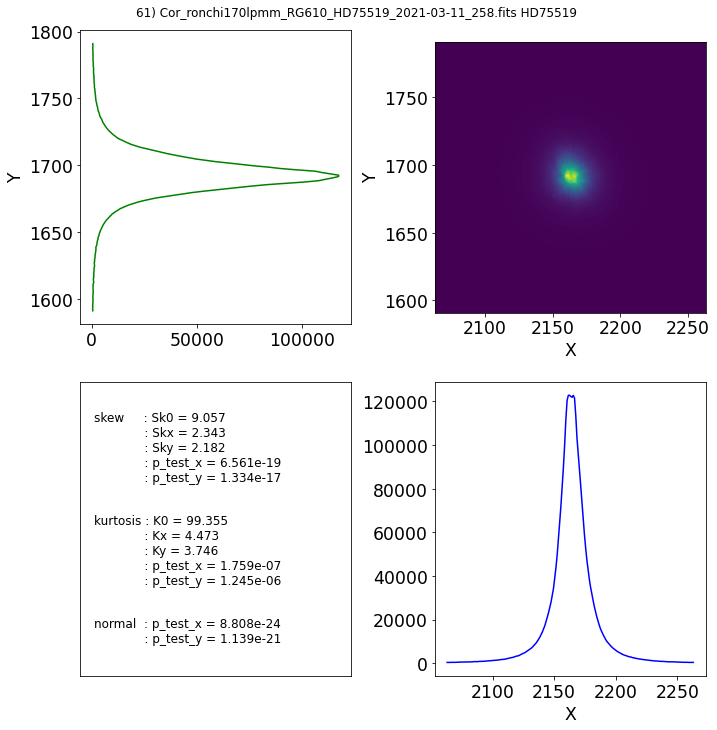

62) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_259.fits HD75519


2021-04-25 15:06:14  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.356816442837 but average of self.read_out_noise is 8.5.


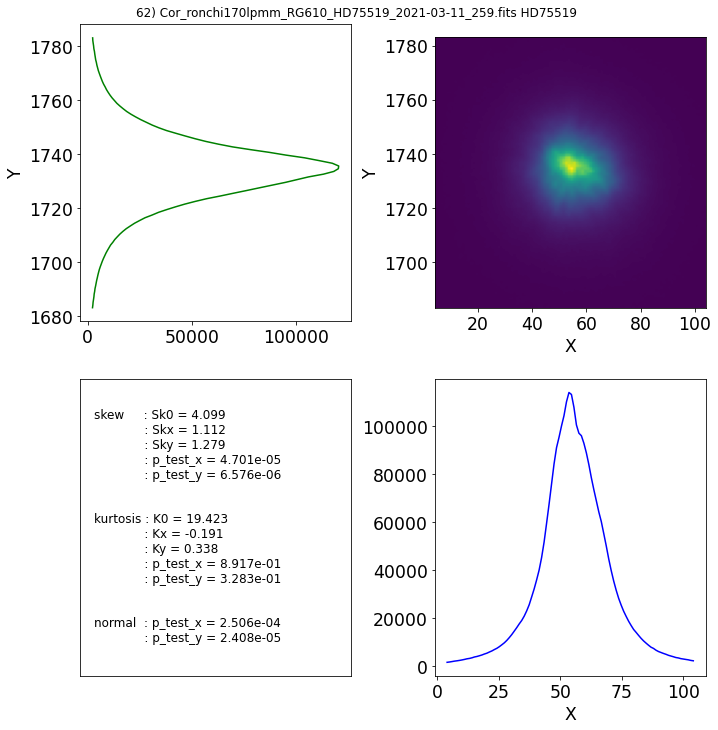

63) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_260.fits HD75519


2021-04-25 15:06:27  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.357411281555112 but average of self.read_out_noise is 8.5.


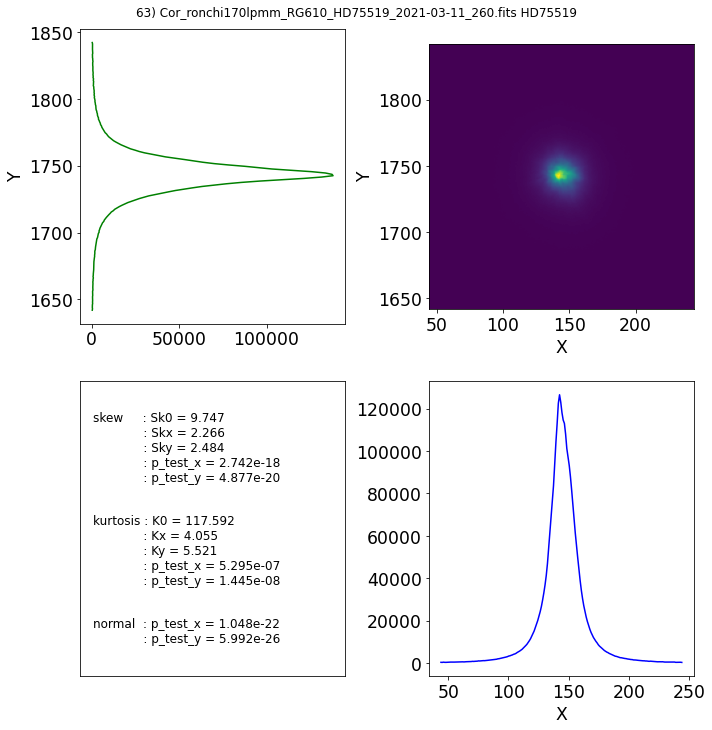

64) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_261.fits HD75519


2021-04-25 15:06:40  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.35739362006159 but average of self.read_out_noise is 8.5.


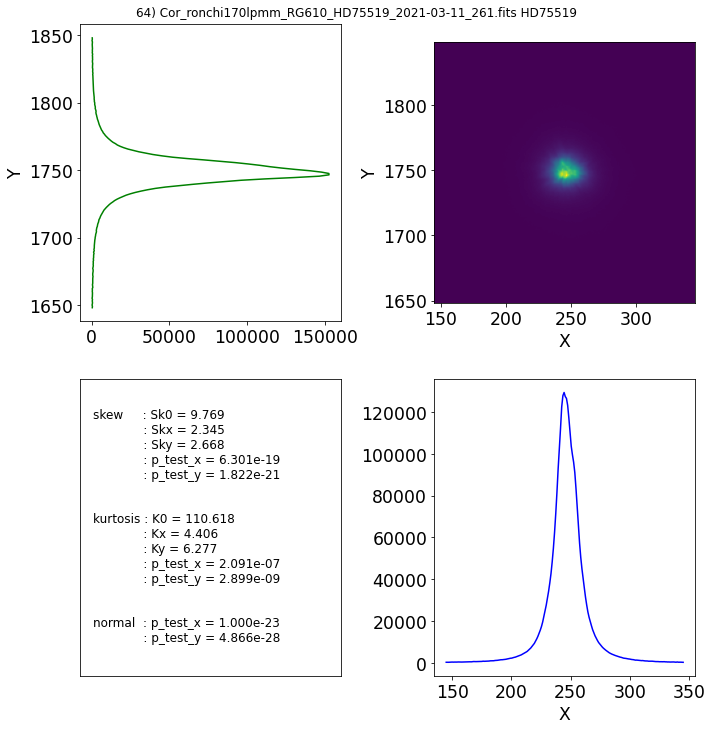

65) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_262.fits HD75519


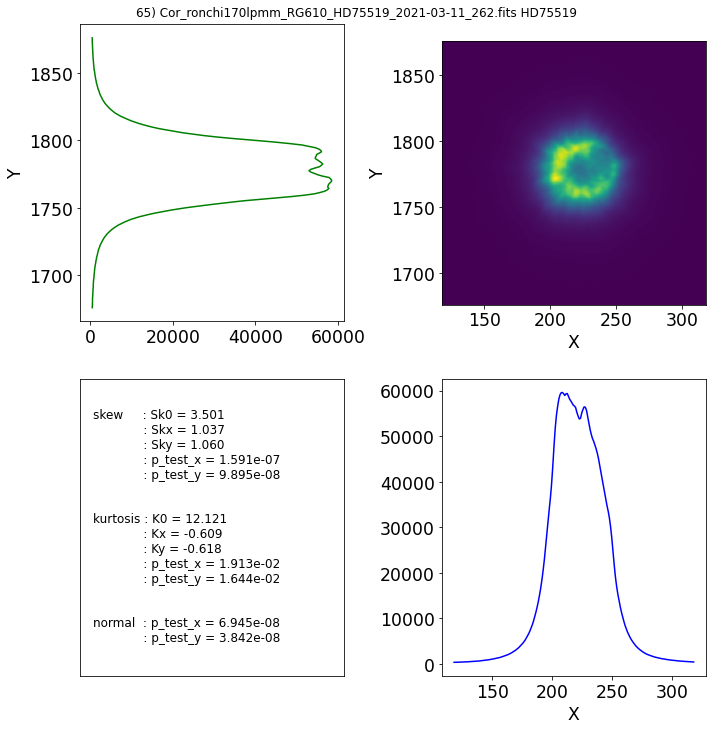

66) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_263.fits HD75519


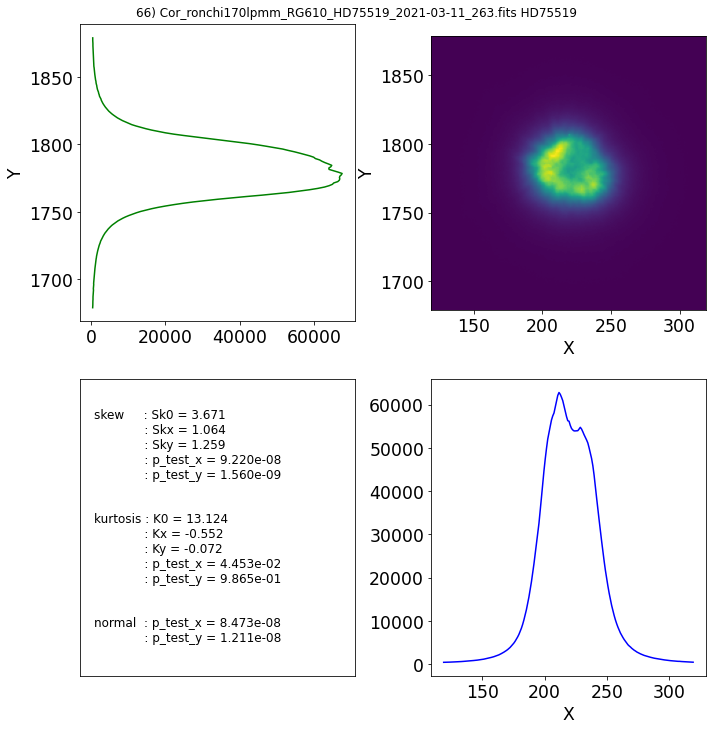

67) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_264.fits HD75519


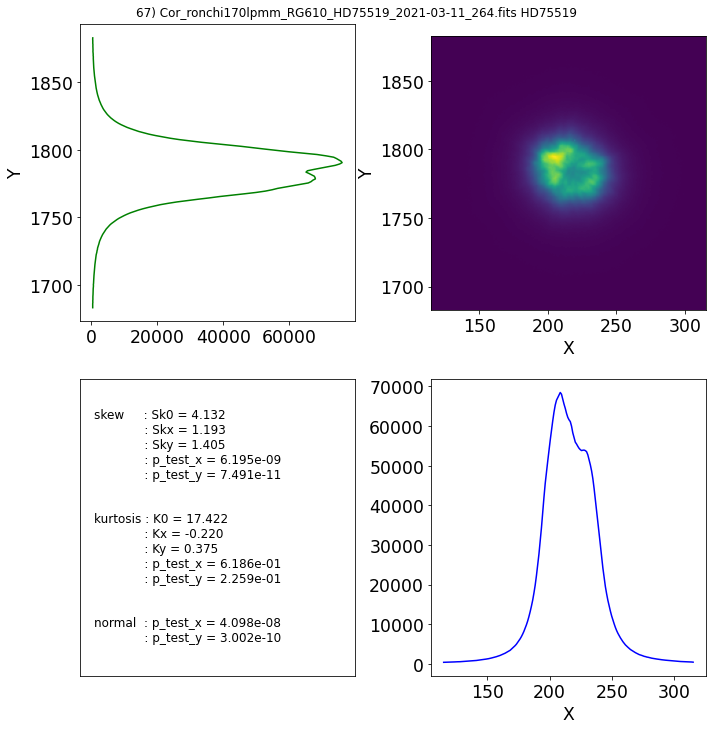

68) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_265.fits HD75519


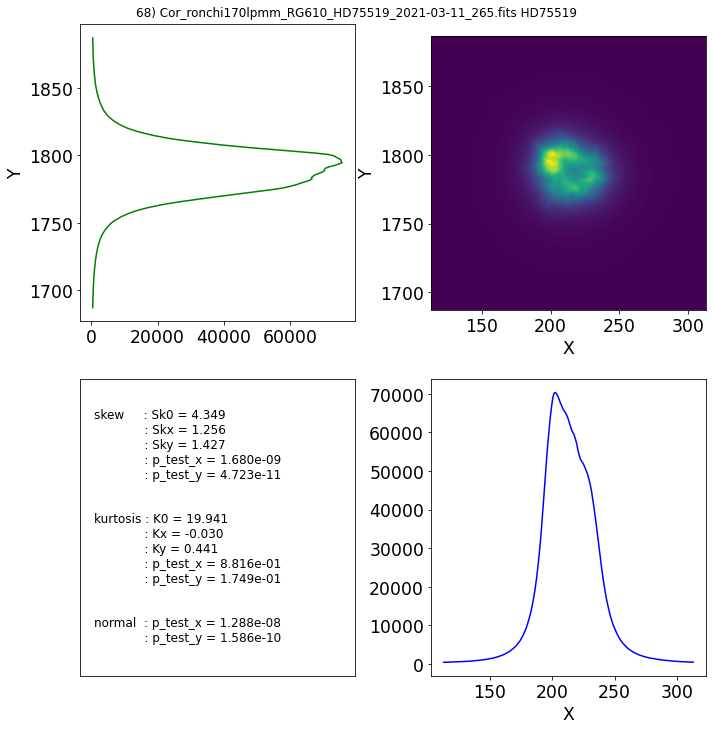

69) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_266.fits HD75519


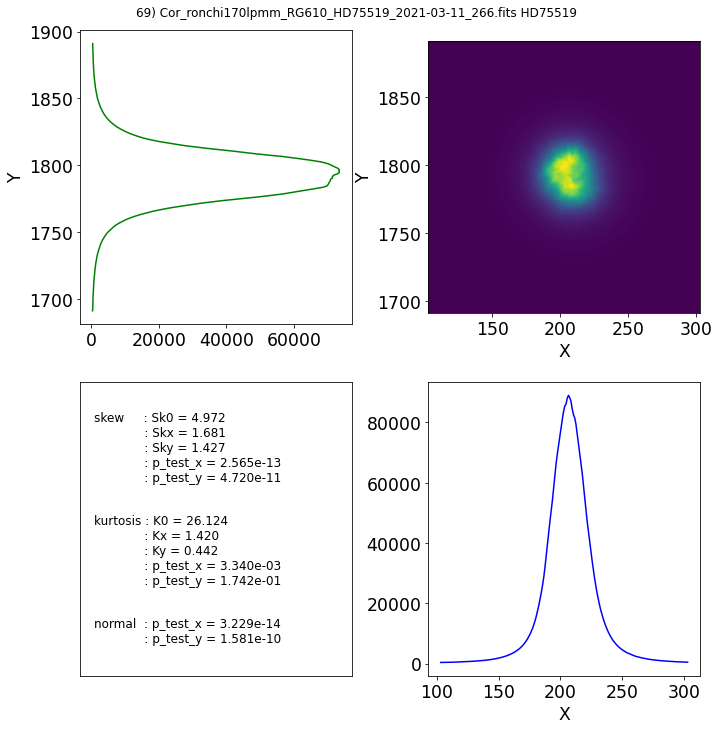

70) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_267.fits HD75519


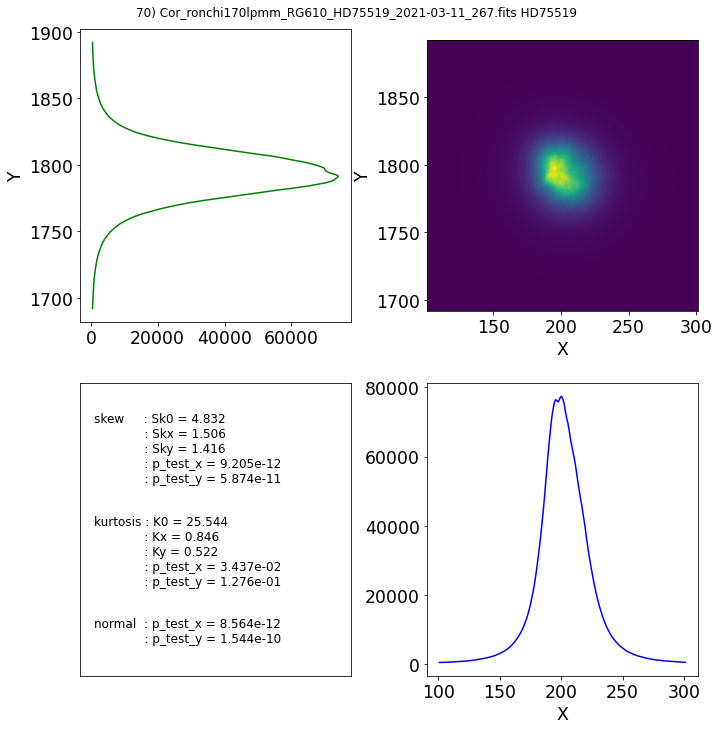

71) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_268.fits HD75519


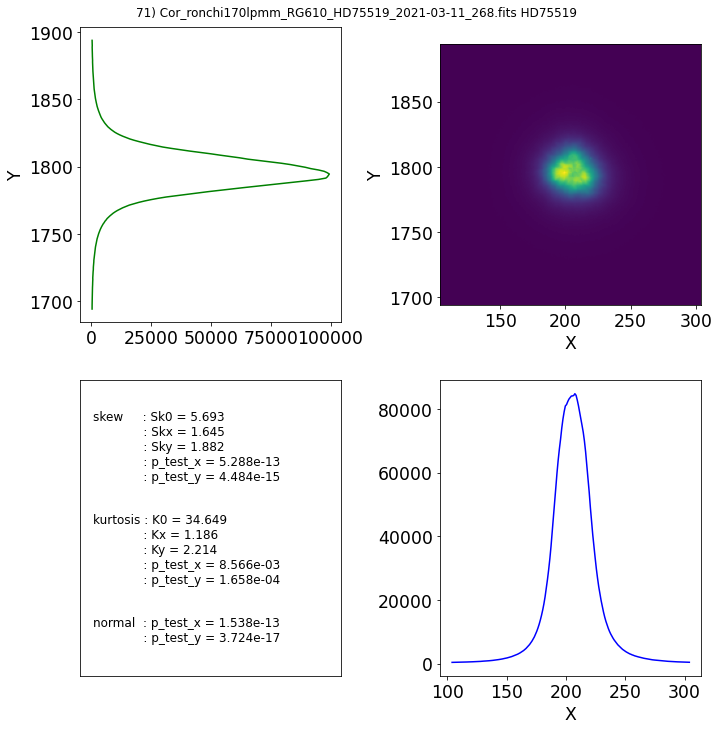

72) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_269.fits HD75519


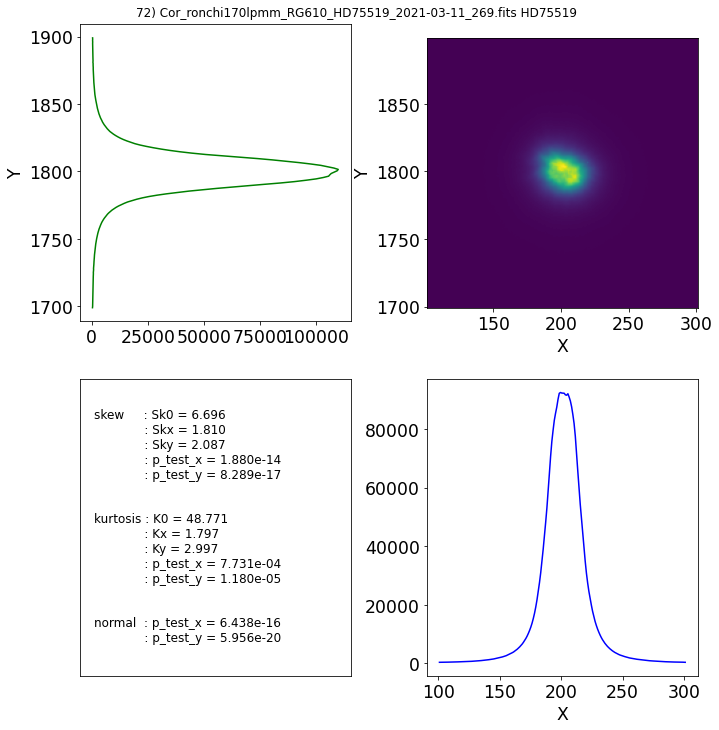

73) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_270.fits HD75519


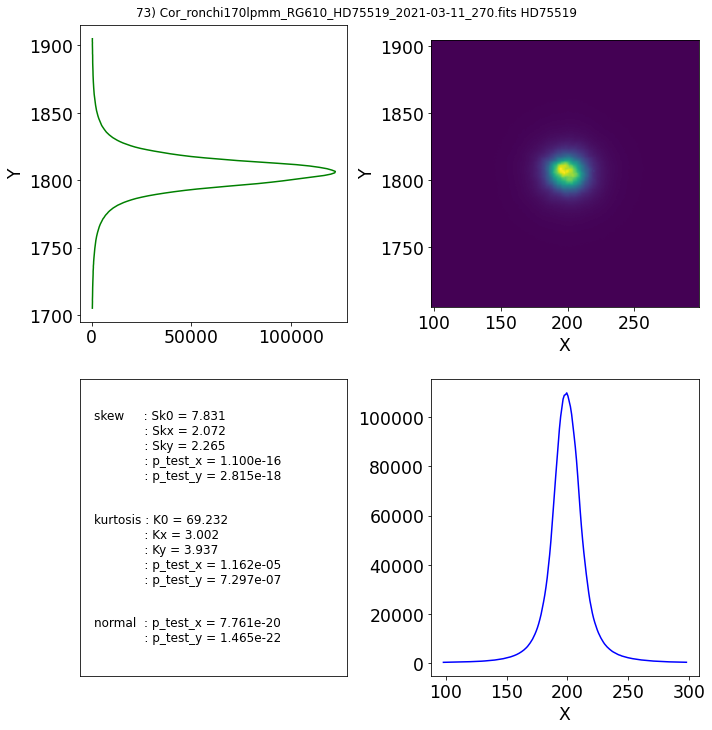

74) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_271.fits HD75519


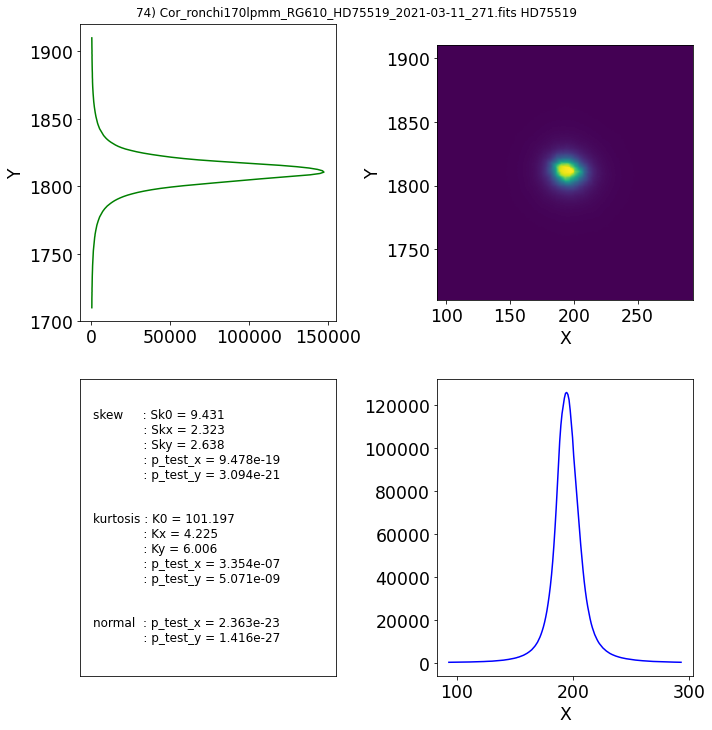

75) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_272.fits HD75519


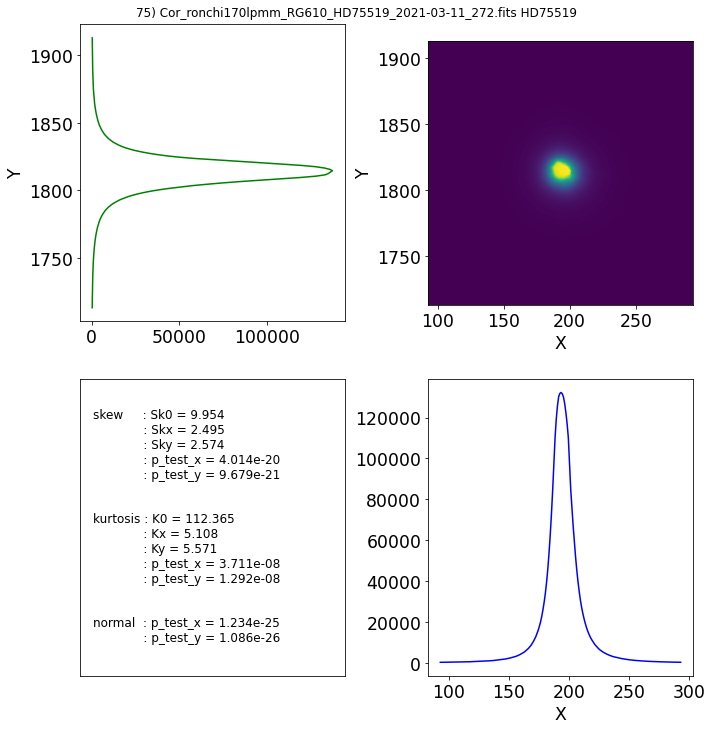

76) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_273.fits HD75519


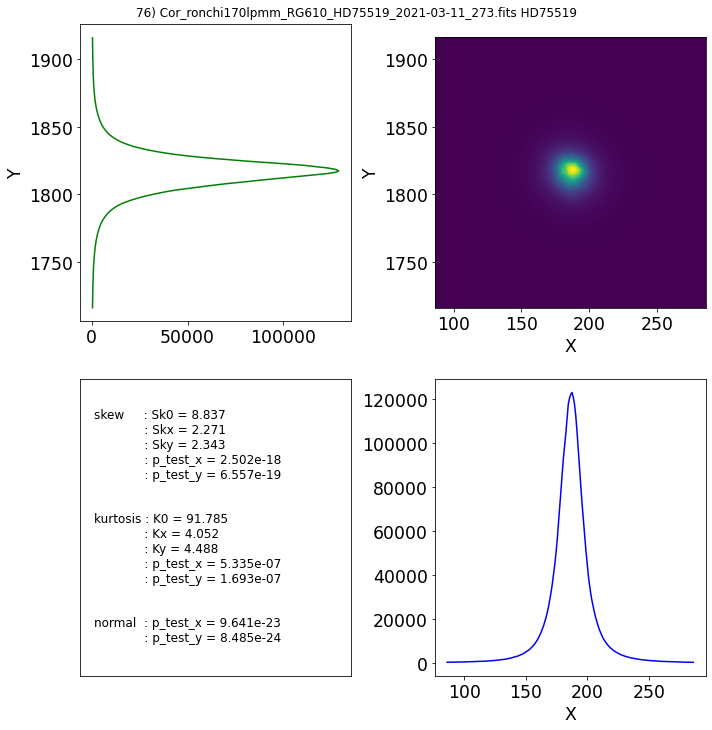

77) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_274.fits HD75519


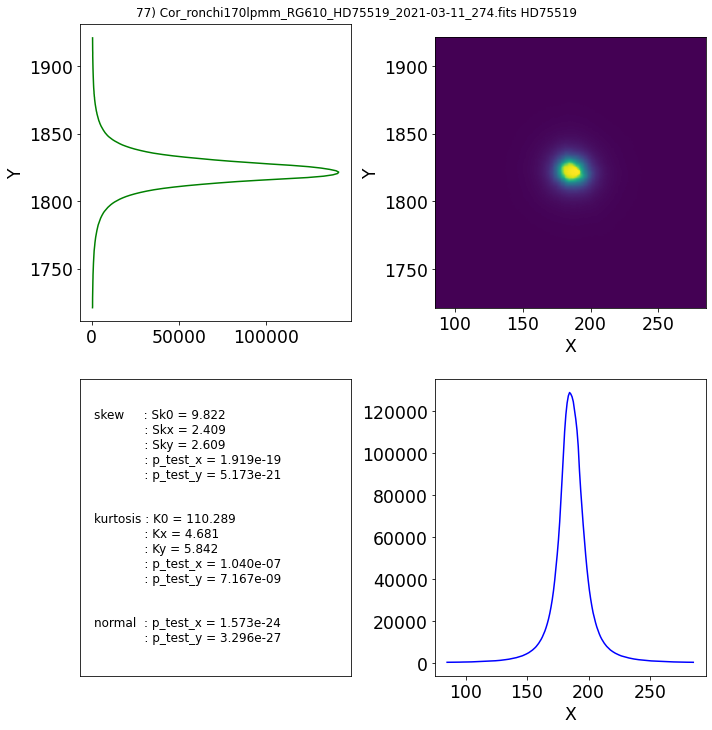

78) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_275.fits HD75519


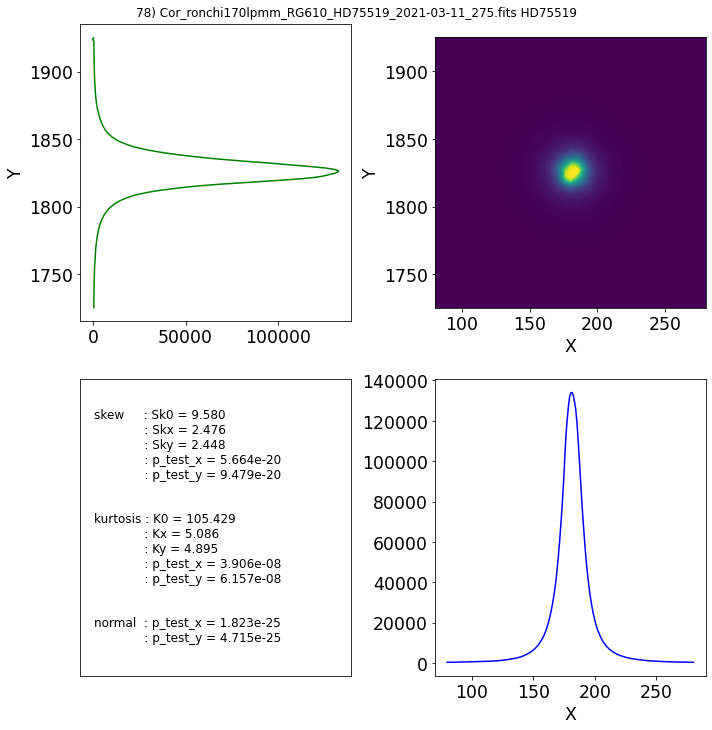

79) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_276.fits HD75519


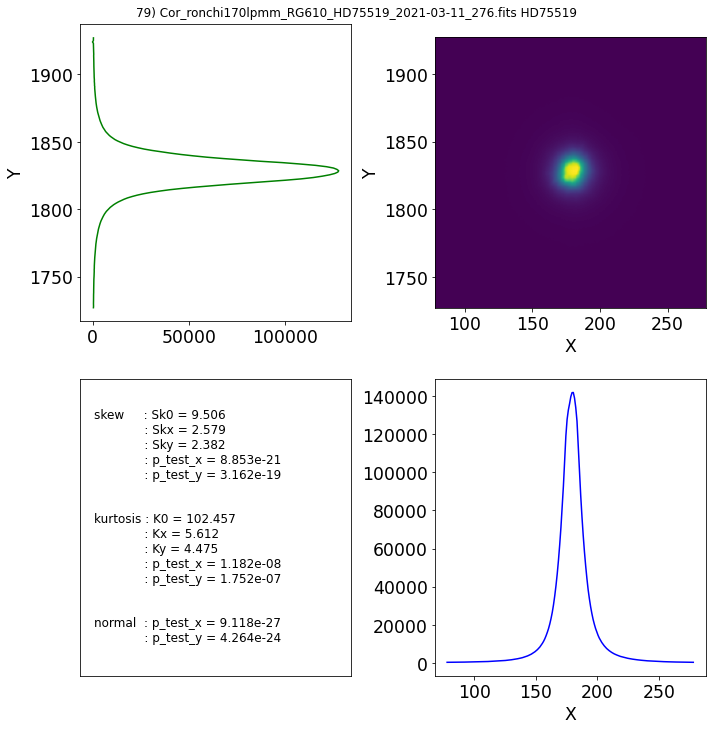

80) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_277.fits HD75519


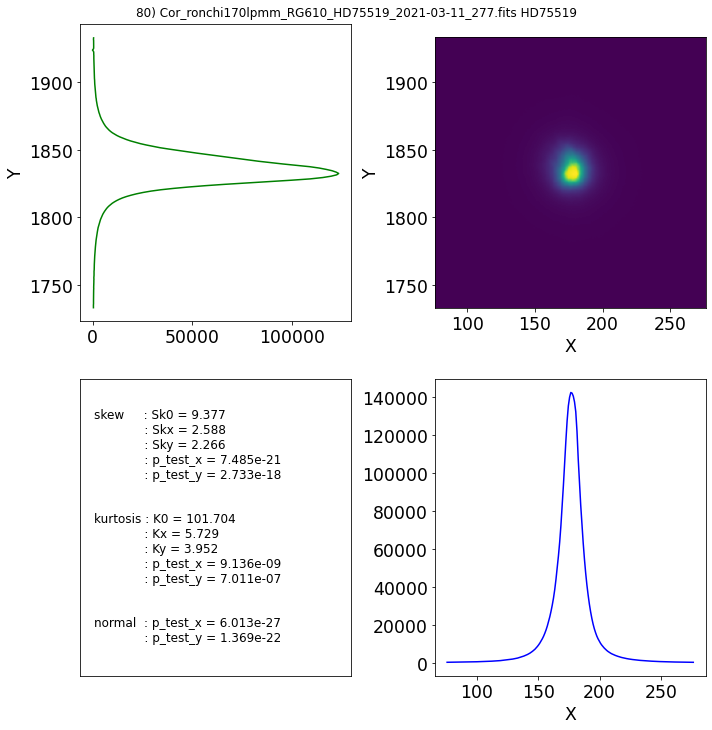

81) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_278.fits HD75519


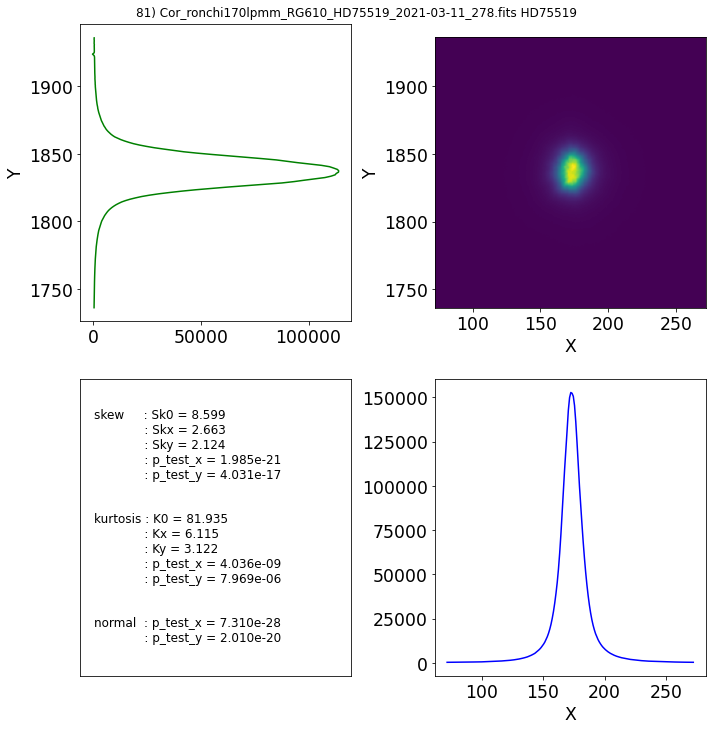

82) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_279.fits HD75519


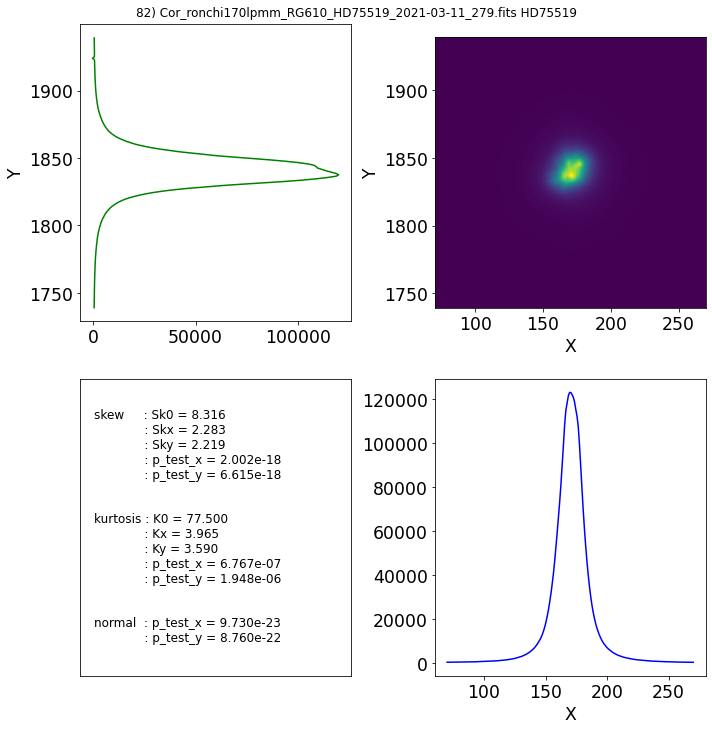

83) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_280.fits HD75519


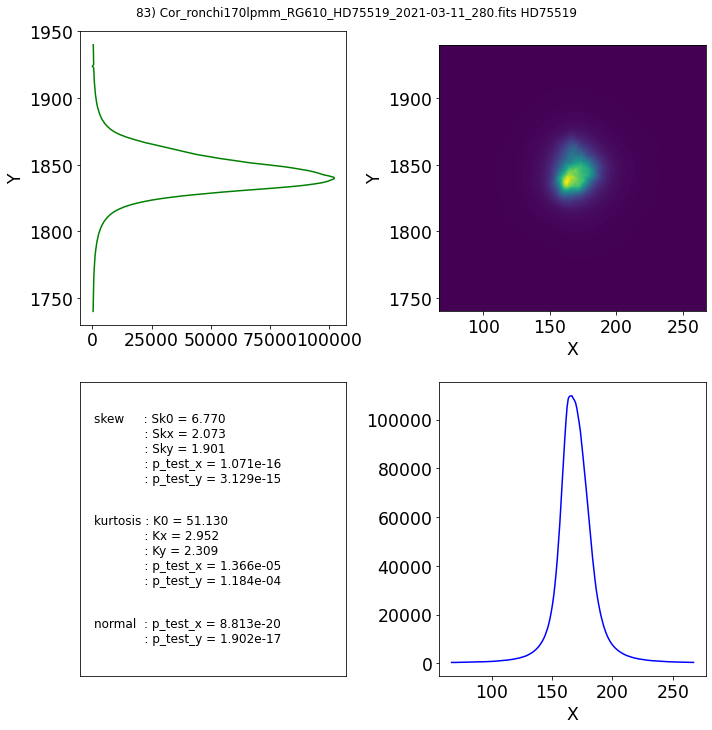

84) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_281.fits HD75519


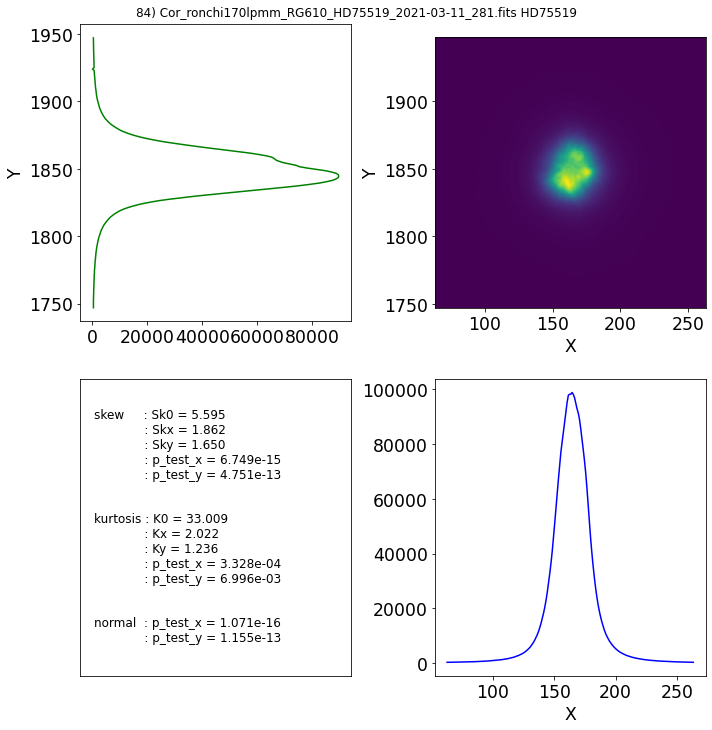

85) Cor_ronchi170lpmm_RG610_HD75519_2021-03-11_282.fits HD75519


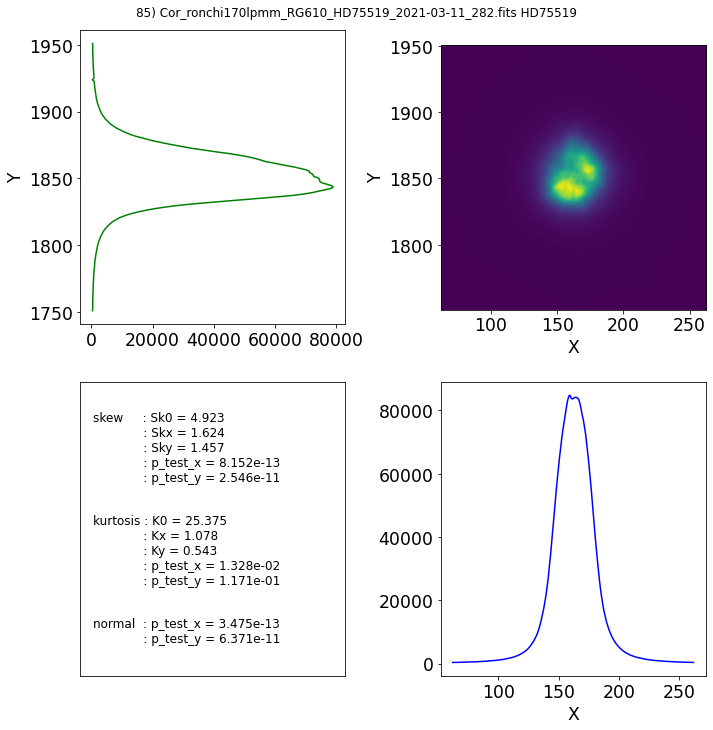

In [27]:

if True:


    idx=0
    infos={}
    
    
    for filename_image in df["file"]:
        
        try:
    
            fullfilename=os.path.join(dir_images,filename_image)
            X=df.iloc[idx]["Obj-posXpix"]
            Y=df.iloc[idx]["Obj-posYpix"]
            guess = [int(X),int(Y)]
            target = file_target(filename_image)[0]
    
            title=str(idx) + ") "+ filename_image + " " + target 
            print(title)
    

            image=Image(file_name=fullfilename, target_label=target, disperser_label=disperser_label, config=config)
            #image.plot_image(figsize=(12, 10),scale="log")
            parameters.VERBOSE = False
            parameters.DEBUG = False
            x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)
    
            if x1>100:
                WID=100
            else:
                WID=50
    

            thumbnail=np.copy(image.data[int(y1)-WID:int(y1)+WID,int(x1)-WID:int(x1)+WID])
            thumbnail_y=thumbnail.sum(axis=1)
            thumbnail_x=thumbnail.sum(axis=0)
            xx=np.linspace(int(x1)-WID,int(x1)+WID,len(thumbnail_x))
            yy=np.linspace(int(y1)-WID,int(y1)+WID,len(thumbnail_y))
            k0=kurtosis(thumbnail,axis=None,bias=True,fisher=True)
            kx=kurtosis(thumbnail_x,bias=True,fisher=True)
            ky=kurtosis(thumbnail_y,bias=True,fisher=True)
            s0=skew(thumbnail,axis=None,bias=True)
            sx=skew(thumbnail_x,bias=True)
            sy=skew(thumbnail_y,bias=True)
            
            
        
            # statistical test
            kurtosis_test_prob=kurtosistest(thumbnail,axis=None).pvalue
            skew_test_prob=skewtest(thumbnail,axis=None).pvalue
            normal_test_prob=normaltest(thumbnail,axis=None).pvalue
            
            kurtosis_test_prob_x=kurtosistest(thumbnail_x).pvalue
            skew_test_prob_x=skewtest(thumbnail_x).pvalue
            normal_test_prob_x=normaltest(thumbnail_x).pvalue       
            
            kurtosis_test_prob_y=kurtosistest(thumbnail_y).pvalue
            skew_test_prob_y=skewtest(thumbnail_y).pvalue
            normal_test_prob_y=normaltest(thumbnail_y).pvalue
        
        
            
            shape_str='\n'.join((
                r'skew     : Sk0 = {:3.3f}, Skx = {:3.3f}, Sky = {:3.3f} \n'.format(s0,sx,sy),
                r'kurtosis : K0  = {:3.3f}, Kx  = {:3.3f},  Ky = {:3.3f}'.format(k0,kx,ky)))
    
            skew_str='\n'.join((
                r'skew     : Sk0 = {:3.3f}'.format(s0),
                r'             : Skx = {:3.3f}'.format(sx),
                r'             : Sky = {:3.3f}'.format(sy),
                r'             : p_test = {:3.3e}'.format(skew_test_prob)))
        
    
            kurt_str='\n'.join((
                r'kurtosis : K0 = {:3.3f}'.format(k0),
                r'             : Kx = {:3.3f}'.format(kx),
                r'             : Ky = {:3.3f}'.format(ky),
                r'             : p_test = {:3.3e}'.format(kurtosis_test_prob)))
        
            norm_str='p_normal_test = {:3.3e}'.format(normal_test_prob)
            
            
            
            skew_str='\n'.join((
                r'skew     : Sk0 = {:3.3f}'.format(s0),
                r'             : Skx = {:3.3f}'.format(sx),
                r'             : Sky = {:3.3f}'.format(sy),
                r'             : p_test_x = {:3.3e}'.format(skew_test_prob_x),
                r'             : p_test_y = {:3.3e}'.format(skew_test_prob_y)))
            
            
            kurt_str='\n'.join((
                r'kurtosis : K0 = {:3.3f}'.format(k0),
                r'             : Kx = {:3.3f}'.format(kx),
                r'             : Ky = {:3.3f}'.format(ky),
                r'             : p_test_x = {:3.3e}'.format(kurtosis_test_prob_x),
                r'             : p_test_y = {:3.3e}'.format(kurtosis_test_prob_y)))
            
        
            norm_str='\n'.join((
                r'normal  : p_test_x = {:3.3e}'.format(normal_test_prob_x),
                r'             : p_test_y = {:3.3e}'.format(normal_test_prob_y)))
        
        
        
            #print("skew_str:",skew_str)
            #print("kurtosis_str:",kurt_str)
            #print("norm_str:",norm_str)
    
            props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)
    
            fig=plt.figure(figsize=(10,10))
            fig.subplots_adjust(left=0.12, right=0.95, wspace=0.3,bottom=0.15, top=0.9)

            ax=fig.add_subplot(222)
            ax.imshow(thumbnail,origin="lower",extent=(int(x1)-WID,int(x1)+WID,int(y1)-WID,int(y1)+WID))
            ax.set_xlabel("X")
            ax.set_ylabel("Y")

            ax=fig.add_subplot(221)
            base = plt.gca().transData
            rot = transforms.Affine2D().rotate_deg(-90)
            #ax.plot(yy,thumbnail_y,"g",rotation=u'vertical')
            ax.plot(-yy,thumbnail_y,"g",transform= rot + base)
            ax.set_ylabel("Y")

            ax=fig.add_subplot(224)
            ax.plot(xx,thumbnail_x,"b")
            ax.set_xlabel("X")
            plt.tight_layout()

            ax=fig.add_subplot(223)
            ax.set_xlim(0,10)
            ax.set_ylim(0,10)
            ax.set_xticklabels([])
            ax.set_xticks([])
            ax.set_yticks([])
            #ax.text(0.05, 0.95, shape_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
            ax.text(0.05, 0.9, skew_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
            ax.text(0.05, 0.55, kurt_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
            ax.text(0.05, 0.2, norm_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
            plt.suptitle(title,Y=1.01)
            plt.show()
        
        
            infos[filename_image] = (s0,sx,sy,k0,kx,ky,
                                      skew_test_prob_x,
                                      skew_test_prob_y,
                                      kurtosis_test_prob_x,
                                      kurtosis_test_prob_y,
                                      normal_test_prob_x,
                                      normal_test_prob_y)
        
        
        except:
            msg=">>> FAILED : "+str(idx) + ") "+ filename_image + " " + target 
            print(msg)
            print(">>> FAILED : guess = ",guess)
    
        
        finally:
            idx+=1

        
        
 

# Add information to logbook

In [67]:
#infos

In [28]:
df_out=df_in

In [68]:
#df_out

In [29]:
N=len(df_out)

In [30]:
all_files=df_out["file"].values

In [31]:
skewness_c=np.full(N,np.nan)
skewness_x_c=np.full(N,np.nan)
skewness_y_c=np.full(N,np.nan)
kurtosis_c=np.full(N,np.nan)
kurtosis_x_c=np.full(N,np.nan)
kurtosis_y_c=np.full(N,np.nan)

probtest_skewness_x_c=np.full(N,np.nan)
probtest_skewness_y_c=np.full(N,np.nan)
probtest_kurtosis_x_c=np.full(N,np.nan)
probtest_kurtosis_y_c=np.full(N,np.nan)
probtest_normal_x_c=np.full(N,np.nan)
probtest_normal_y_c=np.full(N,np.nan)

In [32]:
# loop on rows index
for idx in np.arange(N):
    filename=all_files[idx]
    # check if filename is in dictionnary
    if filename in infos.keys():
        (s0,sx,sy,k0,kx,ky,skew_test_prob_x,skew_test_prob_y,kurtosis_test_prob_x,kurtosis_test_prob_y,normal_test_prob_x,normal_test_prob_y)=infos[filename]
        skewness_c[idx]   = s0
        skewness_x_c[idx] = sx
        skewness_y_c[idx] = sy
        kurtosis_c[idx]   = k0
        kurtosis_x_c[idx] = kx
        kurtosis_y_c[idx] = ky
        probtest_skewness_x_c[idx] = skew_test_prob_x
        probtest_skewness_y_c[idx] = skew_test_prob_y
        probtest_kurtosis_x_c[idx] = kurtosis_test_prob_x
        probtest_kurtosis_y_c[idx] = kurtosis_test_prob_y
        probtest_normal_x_c[idx]   = normal_test_prob_x
        probtest_normal_y_c[idx]   = normal_test_prob_y

In [33]:
df_out["skew"] = skewness_c
df_out["skewx"] = skewness_x_c
df_out["skewy"] = skewness_y_c
df_out["kurtosis"] = kurtosis_c
df_out["kurtosisx"] = kurtosis_x_c
df_out["kurtosisy"] = kurtosis_y_c
df_out["ptskewx"] = probtest_skewness_x_c
df_out["ptskewy"] = probtest_skewness_y_c
df_out["ptkurtx"] = probtest_kurtosis_x_c
df_out["ptkurty"] = probtest_kurtosis_y_c
df_out["ptnormx"] = probtest_normal_x_c
df_out["ptnormy"] = probtest_normal_y_c

In [69]:
#df_out

In [34]:
df_out.to_excel(filename_logbook_out_excel)
df_out.to_csv(filename_logbook_out_csv)

# Plot

Text(0, 0.5, 'skew')

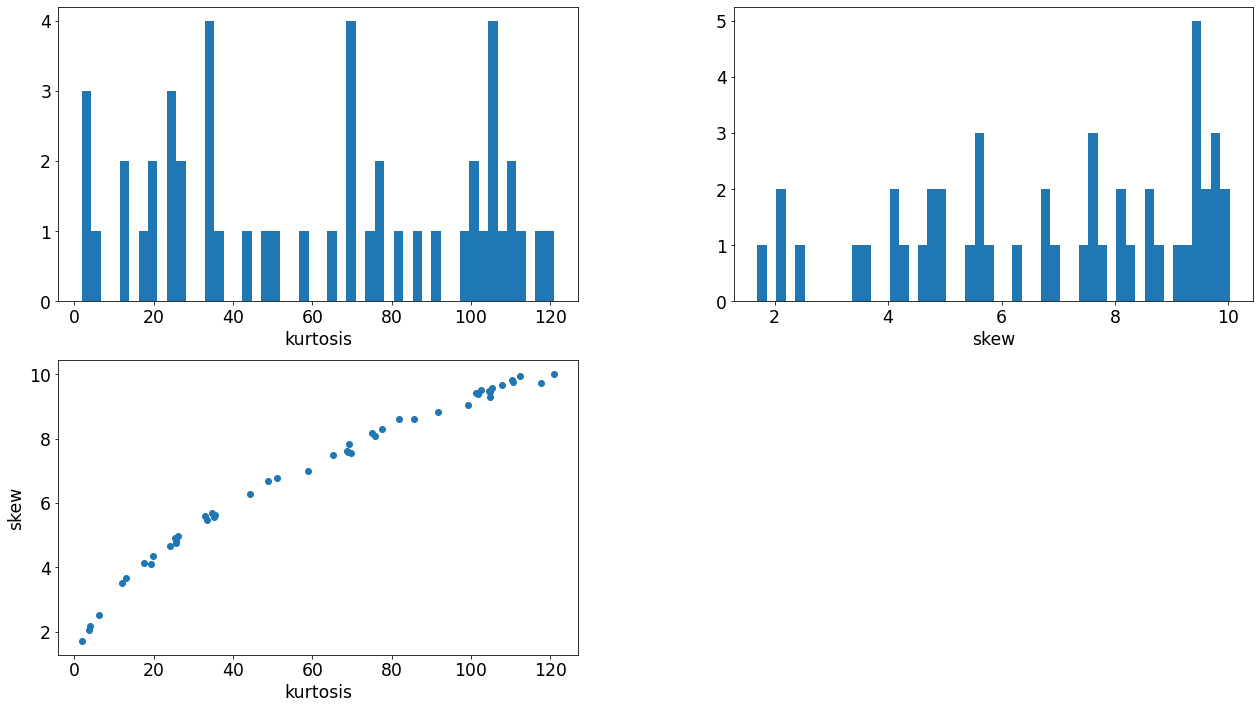

In [35]:
fig=plt.figure(figsize=(20,12))
fig.subplots_adjust(left=0.12, right=0.95, wspace=0.3,bottom=0.15, top=0.9)

ax=fig.add_subplot(221)
ax.hist(df_out["kurtosis"].values,bins=50);
ax.set_xlabel('kurtosis')
ax=fig.add_subplot(222)
ax.hist(df_out["skew"].values,bins=50);
ax.set_xlabel('skew')
ax=fig.add_subplot(223)
ax.scatter(df_out["kurtosis"].values,df_out["skew"].values)
ax.set_xlabel("kurtosis")
ax.set_ylabel("skew")